# Star 

## Packages

In [1]:
import numpy as np
from numpy import correlate
import matplotlib.pyplot as plt
import skysimulation.display as dpl
import skysimulation.stuff as stf
import skysimulation.field as fld
import skysimulation.restoration as rst
from skysimulation.stuff import NDArray, sqr_mask, ArrayLike

## Sky Generation

### Initial Parameters

In [2]:
mass_seed = fld.M_SEED
pos_seed  = fld.POS_SEED
bkg_seed  = fld.BACK_SEED
det_seed  = fld.NOISE_SEED
# mass_seed = None
# pos_seed  = None
# bkg_seed  = None
# det_seed  = None
method = 'rl'
# method = None
last_sen = []

kwargs = {}

### Sky

----------
Initialization of the field
Dimension:	100 x 100
Number of stars:	100

- - - Background - - -
Gaussian distribution
mean:	0.5
sigma:	0.1

- - - Detector noise - - -
Gaussian distribution
mean:	0.05
sigma:	0.025

Atm Seeing:
Gaussian distribution
sigma:	3


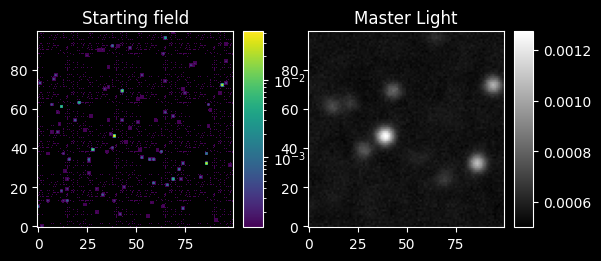

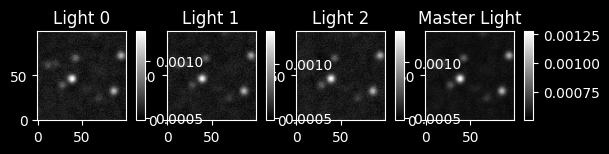

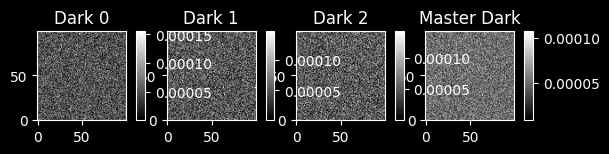

SIGMA = 1.937558131500989e-05 +- 6.856133315823215e-06


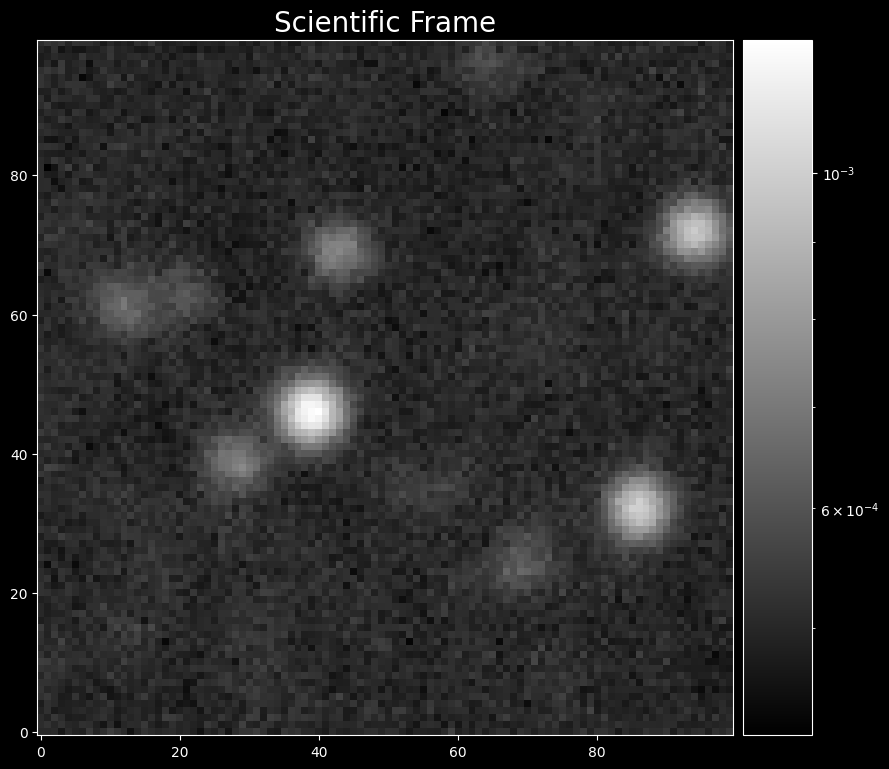

!!CHECK!!	 39


In [3]:
# generate the field
S, (m_light, s_light), (m_dark, s_dark) = fld.field_builder(seed=(mass_seed,pos_seed), back_seed=bkg_seed, det_seed=det_seed,**kwargs)
last_sen += [f'L0: {S.lum.max()}\nL0.5: {m_light.max()*np.sqrt(18*np.pi)}']
# compute the scientific frame
sci_frame = m_light - m_dark
last_sen += [f'L1: {sci_frame.max()*np.sqrt(18*np.pi)}']
# compute the uncertainty
sigma = np.sqrt(s_light**2 + s_dark**2)
m_sigma = sigma.mean()
s_sigma = sigma.std()
print(f'SIGMA = {m_sigma} +- {s_sigma}')
dpl.fast_image(sci_frame,'Scientific Frame',norm='log')
print('!!CHECK!!\t',len(np.where(S.lum > fld.BACK_MEAN*fld.K)[0]))


## Restoration

### Background Estimation


Binning Results
Number of pixels: 10000
Magnitudes: 0.3010299956639812
Number of bins: 664

Background estimation
	mean:	0.0005032792632691882 +- 2.5961678325170145e-06
	sigma:	2.0121896320932656e-05
	relerr:	4.00 %
Back 0.0005 0.0001
0.0005079514622255987
6.035728806462675e-05


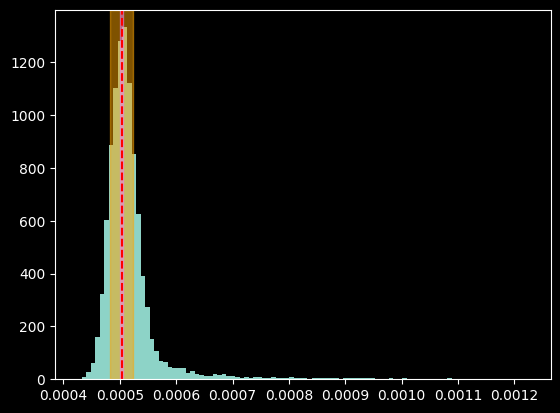

In [4]:
from statistics import pvariance
max_size = 5
# compute the average dark value
mean_dark = m_dark.mean()
# estimate background value
m_bkg, sigma_bkg = rst.bkg_est(sci_frame)
mean_bkg, Dmean_bkg = m_bkg
print('Back',fld.BACK_MEAN*fld.K, fld.BACK_SIGMA*fld.K)
print(np.median(sci_frame))
print(np.sqrt(pvariance(sci_frame.flatten()-np.median(sci_frame))))
plt.figure()
plt.hist(sci_frame.flatten(),sci_frame.shape[0])
plt.axvline(mean_bkg,0,1,color='red',linestyle='dashed')
plt.axvspan(mean_bkg-sigma_bkg,mean_bkg+sigma_bkg,color='orange',alpha=0.5)
plt.axvspan(mean_bkg-Dmean_bkg,mean_bkg+Dmean_bkg,color='violet',alpha=0.5)
plt.show()

### Kernel Estimation

#### New Searching

In [21]:
def art_obj(prb_obj: NDArray, index: tuple[int,int], frame: NDArray, bkg_val: float, ker_sigma: float | None = None) -> NDArray:
    fit_obj = prb_obj.copy() - bkg_val
    # prb_x, prb_y = index
    avg_cen = index 
    def gauss_func(pos, *args):
        xpos, ypos = pos
        k, s, x0, y0 = args
        zx = (xpos-x0)/s
        zy = (ypos-y0)/s
        return k * np.exp(-zx**2/2) * np.exp(-zy**2/2)
    xdim, ydim = prb_obj.shape
    xrange, yrange = np.meshgrid(np.arange(ydim),np.arange(xdim))
    from scipy.optimize import curve_fit
    try:
        k0 = fit_obj[index]
    except:
        dpl.fast_image(fit_obj)
        print(index)
    if ker_sigma is None:
        hm = k0/2
        hm_xpos, hm_ypos = stf.minimum_pos(abs(hm-fit_obj))
        hwhm = np.sqrt((hm_xpos - index[0])**2 + (hm_ypos - index[1])**2)
        ker_sigma = hwhm   
    initial_values = [k0,ker_sigma,index[0],index[1]]  
    xfit = np.vstack((xrange.ravel(),yrange.ravel()))
    yfit = fit_obj.ravel()

    # avg_dist, avg_obj = rst.average_trend(prb_obj,avg_cen)
    # avg_obj -= bkg_val

    # def gauss_func(x,*args):
    #     k,mu,s = args
    #     z = (x-mu)/s
    #     return k * np.exp(-z**2/2)
    # if ker_sigma is None:
    #     avgmax = np.argmax(avg_obj)
    #     hm = avg_obj[avgmax]/2
    #     hm_pos = np.argmin(abs(hm-avg_obj))
    #     hwhm = abs(avg_dist[avgmax]-avg_dist[hm_pos])
    #     ker_sigma = hwhm/np.sqrt(2)
    # initial_values = [avg_obj.max(),0,ker_sigma]
    try:
        # pop, pcov = curve_fit(gauss_func,avg_dist,avg_obj,initial_values)
        pop, pcov = curve_fit(gauss_func,xfit,yfit,initial_values)
        print(pop,np.sqrt(pcov.diagonal()))
    except RuntimeError:
        return None
    # xx = np.linspace(0,avg_dist.max(),100)
    # plt.plot(xx,gauss_func(xx,*pop))
    # plt.plot(xx,gauss_func(xx,*initial_values))
    # zeta = np.sqrt((xrange-avg_cen[0])**2+(yrange-avg_cen[1])**2)/pop[-1]
    # if zeta.shape != prb_obj.shape:
    #     print('Probe',xdim,ydim)
    #     print(xrange)
    #     print(yrange)
    #     print(avg_cen)
    #     print(zeta.shape)
    # rec_obj = np.exp(-zeta**2/2)
    # rec_obj = pop[0]*rec_obj+bkg_val
    
    rec_obj = gauss_func((xrange,yrange),*pop) + bkg_val
    if rec_obj.shape != prb_obj.shape:
        print('Probe',xdim,ydim)
        print(xrange)
        print(yrange)
        print(avg_cen)
        print(rec_obj.shape)
        dpl.fast_image(prb_obj)
        dpl.fast_image(rec_obj)
    print('CENVAL',prb_obj[avg_cen])
    print('CENVAL',rec_obj[avg_cen])
    return rec_obj

from typing import Literal
def searching(field: NDArray, thr: float, bkg_val: float, errs: NDArray | None = None, max_size: int = 7, min_dist: int = 0, ker_sigma: float | None = None, num_objs: int | None = None, cntrl_mode: Literal['bright', 'low', 'all'] = 'all', debug_plots: bool = False, cntrl: int | None = None, cntrl_sel: str | None = None, display_fig: bool = False, **kwargs) -> None | tuple[list[NDArray], list[NDArray] | None, NDArray]:
    if 'log' not in kwargs.keys():
        kwargs['log'] = False
    def info_print(cnt: int, index: tuple, peak: float) -> None:
        x0 , y0 = index
        if kwargs['log']:
            print(f'\n- - - -\nStep {cnt}')
            print(f'\tcoor : ({x0}, {y0})')
            print(f'\tpeak : {peak}')
    tmp_field = field.copy()
    display_field = field.copy()
    sigma = []
    arr_pos = np.empty((2,0),dtype=int)
    acc_obj = []
    err_obj = []
    acc_pos = np.empty((2,0),dtype=int)
    rej_obj = []
    rej_pos = np.empty((2,0),dtype=int)
    
    # first step
    xmax, ymax = stf.peak_pos(tmp_field)    #: coordinates of the maximum
    peak = tmp_field[xmax, ymax]        #: maximum value
    stop_val = thr                      #: threashold
    cnt = 1
    obj_cnt = 0
    print('\n- - - SEARCHING START - - -')
    print(f'Stop_val : {stop_val}')
    info_print(cnt,(xmax, ymax), peak)
    while peak > stop_val:
        rec_obj = None
        # compute an estimation of the size of the object
        xsize, ysize = rst.new_grad_check(tmp_field, (xmax, ymax), thr, size=max_size)
        # compute slices
        x = slice(xmax - xsize[0], xmax + xsize[1]+1)
        y = slice(ymax - ysize[0], ymax + ysize[1]+1)
        # define the object
        obj = field[x,y].copy()
        err = errs[x,y].copy() if errs is not None else None
        if obj_cnt == 0:
            print(xsize,ysize)
            dpl.fast_image(obj)
        if 0 in obj.shape: 
            dpl.fast_image(obj)
            fig, ax = plt.subplots(1,1)
            dpl.field_image(fig,ax,field)
            ax.plot(ymax,xmax,'.')
            plt.show()

        #?
        if debug_plots: dpl.fast_image(obj,'Object')
        #?
        if kwargs['log']: print('SHAPE: ',obj.shape)
        # remove small object
        if obj.shape[0] <= 3 or obj.shape[1] <= 3:
                if kwargs['log']: 
                    print('xsize',xsize)
                    print('ysize',ysize)
                    print('diff',ymax-ysize)
                    print('Shape no Good')
                x0, y0 = xmax, ymax
                rej_obj += [obj]
                rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                #? 
                if debug_plots:          
                    fig0, ax0 = plt.subplots(1,1)
                    ax0.set_title('Rejected')
                    dpl.field_image(fig0,ax0,display_field)
                    if len(acc_pos[0]) != 0:
                        ax0.plot(acc_pos[1],acc_pos[0],'.b')
                    ax0.plot(rej_pos[1],rej_pos[0],'.r')
                    ax0.plot(y0,x0,'xr')
                    plt.show()
                #?
        else:
            if cntrl_sel is not None and cntrl_sel == 'low': debug_plots = False
            cxmax, cymax = stf.peak_pos(obj)
            if kwargs['log']:
                print('          c s')
                print('x compare',cxmax,xsize)
                print('y compare',cymax,ysize)
            remove_cond = False
            while cxmax != xsize[0] or cymax != ysize[0]:
                #?
                if debug_plots:    
                    ff, aa = plt.subplots(1,1)
                    ff.suptitle('Have to reduce')            
                    dpl.field_image(ff,aa,obj)
                    aa.plot(cymax,cxmax,'.r')
                    aa.plot(ysize[0],xsize[0],'.b')
                    plt.show()
                #?
                row = min(cxmax, obj.shape[0]-cxmax-1)
                col = min(cymax, obj.shape[1]-cymax-1)
                condition = row <= col if all([cxmax != xsize[0], cymax != ysize[0]]) else cymax == ysize[0]
                if condition:
                    if kwargs['log']: print('row',cxmax, obj.shape[0]-cxmax-1)
                    xsize = np.array([xsize[0]-cxmax-1, xsize[1]]) if cxmax < xsize[0] else np.array([xsize[0], cxmax-xsize[0]-1])
                    if kwargs['log']: print(xsize)
                else:
                    if kwargs['log']: print('col',cymax, obj.shape[1]-cymax-1)
                    ysize = np.array([ysize[0]-cymax-1, ysize[1]]) if cymax < ysize[0] else np.array([ysize[0], cymax-ysize[0]-1])
                    if kwargs['log']: print(ysize)
                if kwargs['log']:
                    print('x compare',cxmax,xsize)
                    print('y compare',cymax,ysize)
                if (xsize < 0).any() or (ysize < 0).any():
                    raise Exception('Void object')
                # compute slices
                x = slice(xmax - xsize[0], xmax + xsize[1]+1)
                y = slice(ymax - ysize[0], ymax + ysize[1]+1)
                # define the object
                obj = field[x,y].copy()
                if errs is not None:
                    err = errs[x,y].copy()
                if (obj.shape[0] <= 3) or (obj.shape[1] <= 3):
                    if kwargs['log']: print('remove')
                    remove_cond = True
                    break
                cxmax, cymax = stf.peak_pos(obj)
            if remove_cond:            
                if kwargs['log']: print('New Shape is too small')
                x0, y0 = xmax, ymax
                rej_obj += [obj]
                rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                #?
                if debug_plots:
                    fig0, ax0 = plt.subplots(1,1)
                    ax0.set_title('Rejected')
                    dpl.field_image(fig0,ax0,display_field)
                    if len(acc_pos[0]) != 0:
                        ax0.plot(acc_pos[1],acc_pos[0],'.b')
                    ax0.plot(rej_pos[1],rej_pos[0],'.r')
                    ax0.plot(y0,x0,'xr')
                    plt.show()
                #?
            elif peak/2 >= bkg_val:       #: bright objects
                #?
                if debug_plots:                
                    dpl.fast_image(obj,'Object before check')
                #?
                if kwargs['log']: print(f'\tshape : {obj.shape}')     
                #?
                if debug_plots:       
                    fig0, ax0 = plt.subplots(1,1)
                    dpl.field_image(fig0,ax0,display_field)
                    ax0.plot(ymax,xmax,'.')
                #?
                # check if object is acceptable
                check = rst.object_check(obj, (xmax, ymax), bkg_val, sigma, err=err, debug_plots=debug_plots,**kwargs)
                if check is None:
                    if kwargs['log']: print('Check is not good 1')
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                # elif check == -1:
                #     break
                else:
                    obj, err, (x0, y0), (xsize, ysize) = check
                    if kwargs['log']:
                        print('xsize',xsize)
                        print('ysize',ysize)
                    # compute slices
                    x = slice(*xsize)
                    y = slice(*ysize)
                    #?
                    if debug_plots:
                        figg, axx = plt.subplots(1,2)
                        dpl.field_image(figg,axx[0],obj)
                        dpl.field_image(figg,axx[1],display_field[x,y])
                        plt.show()
                    #?
                    # check 
                    if rst.selection(obj,(x0, y0), arr_pos, max_size,  mindist=min_dist, sel='all'):
                        xcen = x0 - x.indices(x0)[0]
                        ycen = y0 - y.indices(y0)[0]
                        rec_obj = art_obj(obj,(xcen,ycen),field,bkg_val=bkg_val,ker_sigma=ker_sigma)
                        # acc_obj += [obj]
                        if rec_obj is not None:
                            obj_cnt += 1
                            acc_obj += [rec_obj]
                            err_obj += [err]
                            acc_pos = np.append(acc_pos, [[x0], [y0]], axis=1)
                            display_field[x,y] -= rec_obj
                        else:
                            rej_obj += [obj]
                            rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)

                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Accepted')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(rej_pos[0]) != 0:
                                ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(y0,x0,'xb')
                            plt.show()
                        #?
                    else:
                        if kwargs['log']: print('No for selection')
                        rej_obj += [obj]
                        rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Rejected')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(acc_pos[0]) != 0:
                                ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(y0,x0,'xr')
                            plt.show()
                        #?
            else:       #: faint objects
                
                if cntrl_sel is not None and cntrl_sel == 'low': debug_plots = True
                #?
                if debug_plots:
                    fig0, ax0 = plt.subplots(1,1)
                    dpl.field_image(fig0,ax0,display_field)
                    ax0.plot(ymax,xmax,'.')
                #?
                # check whether the object is acceptable
                check = rst.object_check(obj, (xmax, ymax), bkg_val, sigma, mode='low', err=err, maxpos=(xsize[0],ysize[0]), debug_plots=debug_plots)
                if check is None:
                    if kwargs['log']: print('Check is not good 2')
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:                    
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                elif check == -1:
                    x0, y0 = xmax, ymax
                    rej_obj += [obj]
                    rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                    #?
                    if debug_plots:                    
                        fig0, ax0 = plt.subplots(1,1)
                        ax0.set_title('Rejected')
                        dpl.field_image(fig0,ax0,display_field)
                        if len(acc_pos[0]) != 0:
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                        ax0.plot(rej_pos[1],rej_pos[0],'.r')
                        ax0.plot(y0,x0,'xr')
                        plt.show()
                    #?
                    break
                else:
                    obj, err, (x0, y0), (xsize, ysize) = check
                    if kwargs['log']:
                        print('xsize',xsize)
                        print('ysize',ysize)
                    # compute slices
                    x = slice(*xsize)
                    y = slice(*ysize)
                    #?
                    if debug_plots:
                        figg, axx = plt.subplots(1,2)
                        dpl.field_image(figg,axx[0],obj)
                        dpl.field_image(figg,axx[1],display_field[x,y])
                        plt.show()
                    #?
                    if rst.selection(obj,(x0, y0), arr_pos, max_size,  mindist=min_dist, sel='all'):
                        xcen = x0 - x.indices(x0)[0]
                        ycen = y0 - y.indices(y0)[0]
                        rec_obj = art_obj(obj,(xcen,ycen),field,bkg_val=bkg_val,ker_sigma=ker_sigma)
                        if rec_obj is not None:
                            obj_cnt += 1
                            acc_obj += [rec_obj]
                            err_obj += [err]
                            acc_pos = np.append(acc_pos, [[x0], [y0]], axis=1)
                            display_field[x,y] -= rec_obj
                        else:
                            rej_obj += [obj]
                            rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Accepted')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(rej_pos[0]) != 0:
                                ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(y0,x0,'xb')
                            plt.show()
                        #?
                    else:
                        if kwargs['log']: print('No good for selection low obj')
                        rej_obj += [obj]
                        rej_pos = np.append(rej_pos, [[x0], [y0]], axis=1)
                        #?
                        if debug_plots:
                            fig0, ax0 = plt.subplots(1,1)
                            ax0.set_title('Rejected')
                            dpl.field_image(fig0,ax0,display_field)
                            if len(acc_pos[0]) != 0:
                                ax0.plot(acc_pos[1],acc_pos[0],'.b')
                            ax0.plot(rej_pos[1],rej_pos[0],'.r')
                            ax0.plot(y0,x0,'xr')
                            plt.show()
                        #?
        # collect coordinates of the centre
        arr_pos = np.append(arr_pos, [[x0], [y0]], axis=1)
        
        if rec_obj is None:
            tmp_field[x,y] = 0.0
        else:
            try:
                # update the field
                tmp_field[x,y] -= rec_obj
            except:
                print(x,y)
                print(x0,y0)
                print(xcen,ycen)
                dpl.fast_image(rec_obj)
                dpl.fast_image(obj)
                dpl.fast_image(tmp_field[x,y])
                print(tmp_field[x,y].shape)
                print(obj.shape)
                print(rec_obj.shape)

        old_data = (xmax, ymax)
        # compute the next step
        xmax, ymax = stf.peak_pos(tmp_field)
        #!
        if old_data == (xmax,ymax): 
            edge = lambda centre : slice(max(0,centre-4),min(len(field),centre+4))
            f, a = plt.subplots(1,2)
            f.suptitle('Ripetition')
            dpl.field_image(f,a[0],display_field)
            dpl.field_image(f,a[1],display_field[edge(arr_pos[0,-1]),edge(arr_pos[1,-1])])
            a[0].plot(arr_pos[1,-1],arr_pos[0,-1],'.')
            dpl.fast_image(rej_obj[-1],'Bad')
            raise Exception('! RIPETITION !')
        #!
        peak = tmp_field[xmax, ymax]   
        cnt += 1
        info_print(cnt,(xmax, ymax), peak)
        #?
        if debug_plots: dpl.fast_image(tmp_field,'tmp_field')
        #?
        if cnt == cntrl:
            raise Exception('Stop for control')
        if obj_cnt == num_objs:
            break
                
    fig, ax = plt.subplots(1,1)
    dpl.field_image(fig,ax,display_field)
    if len(acc_pos[0]) != 0:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    if len(rej_pos[0]) != 0:
        ax.plot(rej_pos[1],rej_pos[0],'.r')
    if 0 not in acc_pos:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    if 0 not in rej_pos:
        ax.plot(rej_pos[1],rej_pos[0],'.r')
    plt.show()
    fig, ax = plt.subplots(1,1)
    dpl.field_image(fig,ax,field)
    if 0 not in acc_pos:
        ax.plot(acc_pos[1],acc_pos[0],'.b')
    plt.show()
    if 0 in acc_pos.shape: return None
    if errs is None: err_obj = None
    return acc_obj, err_obj, acc_pos



- - - SEARCHING START - - -
Stop_val : 0.0005234011595901208

	hwhm 5
	hm_pos 10
	sigma 3.6067376022224087
	dim :  11 11
	cen :  5 5
	x :  0 11
	y :  0 11
	val0 0.0012246721326269684
	cen :  5 5
	shift [0 0]
	val1 0.0012246721326269684
	cen :  5 5
	shift [0 0]
	val1 0.0012246721326269684

sigma0 = 2.0402788931935794

Fit results:
	k: 0.00073 +- 2.6e-05
	sigma: 3.0 +- 0.082
	x0: 4.9 +- 0.13
	y0: 4.0 +- 0.14
	red_chi = 5.29 +- 13.07 %

	hwhm 4
	hm_pos 9
	sigma 2.8853900817779268
	dim :  11 11
	cen :  5 4
	x :  1 10
	y :  0 9
	val0 0.001203079174729971
	cen :  4 4
	shift [1 0]
	val1 0.001203079174729971
	cen :  4 4
	shift [1 0]
	val1 0.001203079174729971
[7.30657298e-04 3.04188753e+00 3.96317369e+00 4.96112537e+00] [5.69435544e-06 1.94135933e-02 2.41373912e-02 2.34619616e-02]
CENVAL 0.001203079174729971
CENVAL 0.0012338233593216141

sigma0 = 2.0402788931935794

Fit results:
	k: 0.00051 +- 1.7e-05
	sigma: 3.0 +- 0.083
	x0: 5.1 +- 0.14
	y0: 6.0 +- 0.14
	red_chi = 10.97 +- 13.07 %
[5.052500

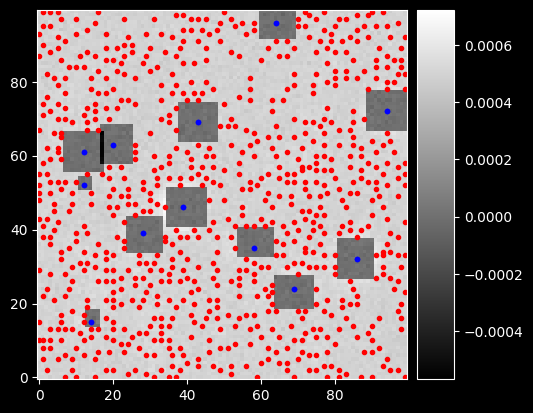

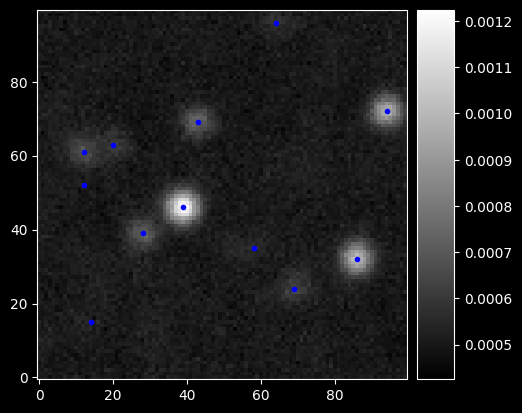


sigma0 = 2.600855472391387

Fit results:
	k: 0.00073 +- 1.5e-05
	sigma: 3.0 +- 0.072
	x0: 5.0 +- 0.13
	y0: 4.0 +- 0.14
	red_chi = 0.00 +- 13.07 %

sigma0 = 2.600855472391387

Fit results:
	k: 0.00051 +- 1.6e-05
	sigma: 3.1 +- 0.08
	x0: 5.1 +- 0.12
	y0: 5.0 +- 0.13
	red_chi = 0.00 +- 13.74 %

sigma0 = 2.600855472391387

Fit results:
	k: 0.00047 +- 1.7e-05
	sigma: 3.0 +- 0.071
	x0: 4.9 +- 0.12
	y0: 5.1 +- 0.12
	red_chi = 0.00 +- 13.07 %

sigma0 = 2.8853900817779268

Fit results:
	k: 0.00021 +- 8.8e-06
	sigma: 3.2 +- 0.12
	x0: 4.9 +- 0.17
	y0: 4.2 +- 0.16
	red_chi = 0.00 +- 14.43 %

sigma0 = 2.600855472391387

Fit results:
	k: 0.00024 +- 8.7e-06
	sigma: 2.9 +- 0.085
	x0: 5.1 +- 0.15
	y0: 4.9 +- 0.15
	red_chi = 0.00 +- 13.07 %

sigma0 = 3.225964182229561

Fit results:
	k: 0.00016 +- 6.6e-06
	sigma: 3.4 +- 0.12
	x0: 5.3 +- 0.16
	y0: 5.3 +- 0.16
	red_chi = 0.00 +- 13.07 %

sigma = 3.06380 +- 0.11724 -> 3.8 %


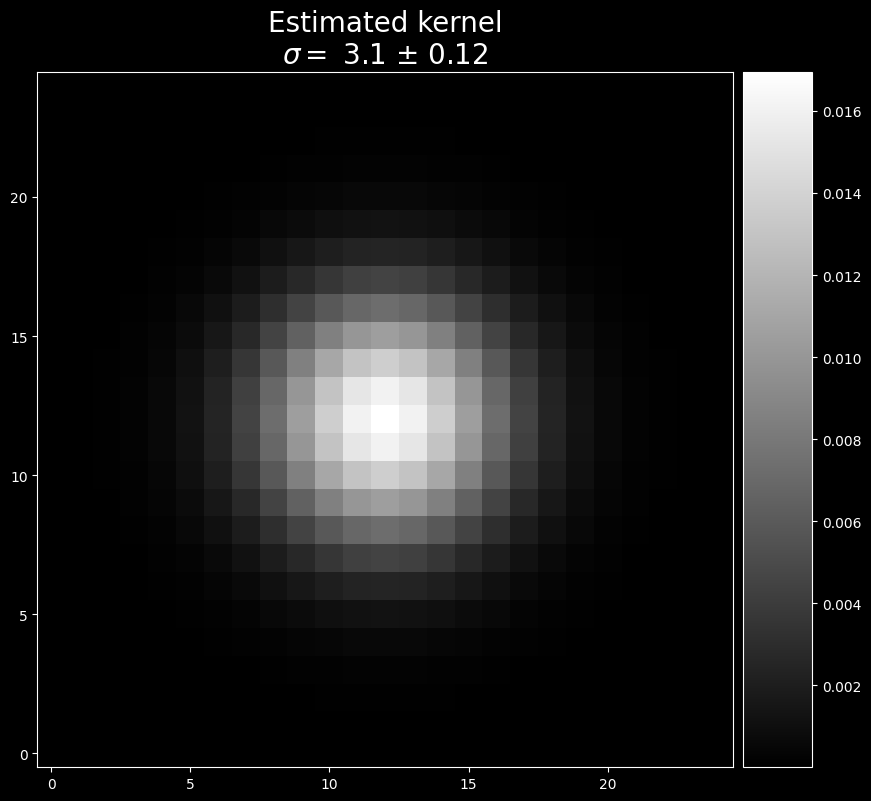

In [12]:

objs, errs, pos = searching(sci_frame, mean_bkg+Dmean_bkg, mean_bkg, errs=sigma, max_size=max_size, min_dist=2, cntrl_mode='bright', display_fig=False,**kwargs)

ker_sigma, ker_Dsigma = rst.kernel_estimation(objs[:6], errs[:6], m_bkg, display_plot=False,**kwargs)
kernel = stf.Gaussian(ker_sigma)


#### II method

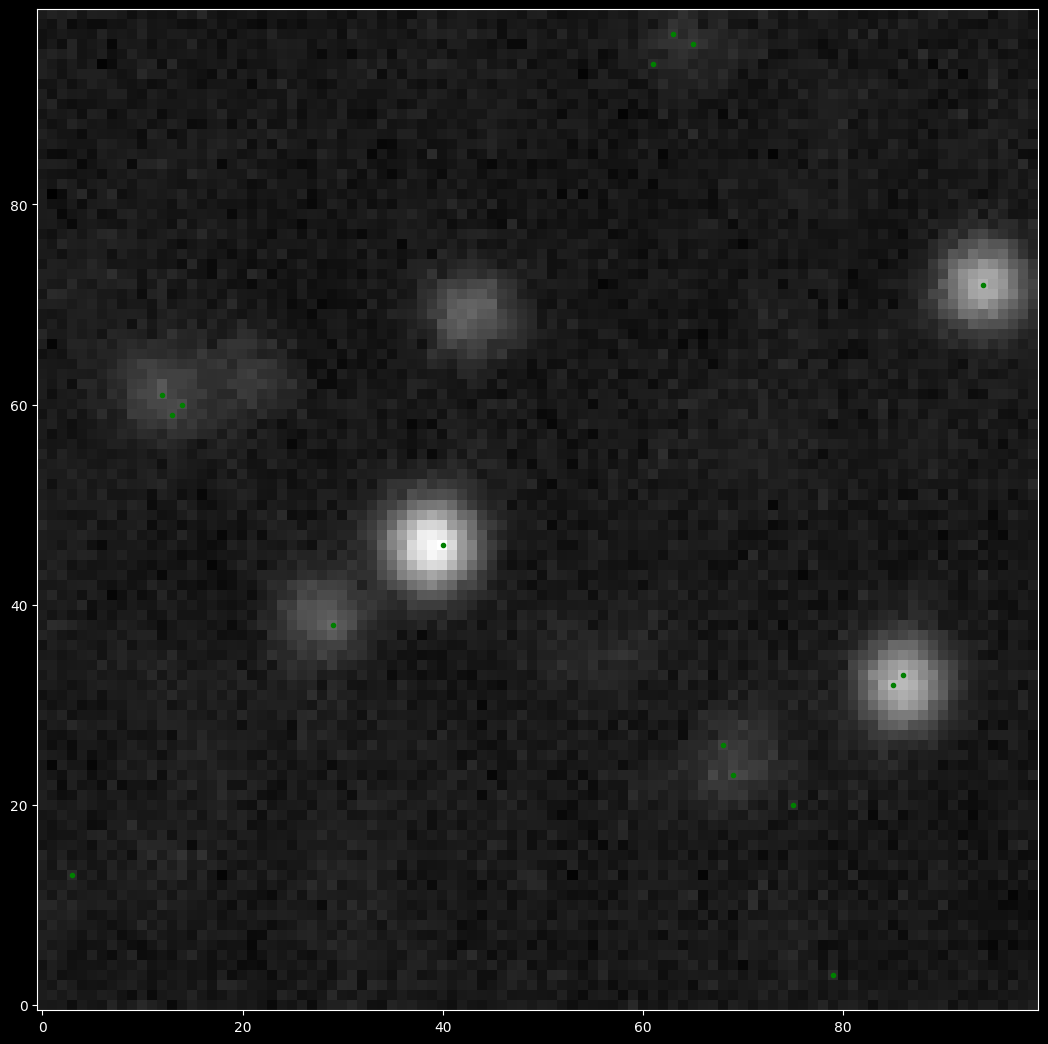

[0.00048992 0.00050187 0.00049434 0.00048435 0.00049529 0.00051775
 0.00049743 0.0005053  0.00054805 0.00050951 0.00052078 0.00052039
 0.00047435 0.00047301 0.00054631 0.00051972]
[0.00047301 0.00047435 0.00048435 0.00048992 0.00049434 0.00049529
 0.00049743 0.00050187 0.0005053  0.00050951 0.00051775 0.00051972
 0.00052039 0.00052078 0.00054631 0.00054805]
[ 8 14 10 11 15  5  9  7  1  6  4  2  0  3 12 13]


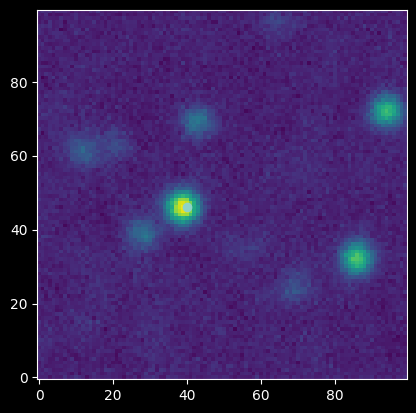

(46, 40)
(96, 65)
(60, 14)
(61, 12)
(97, 63)
(32, 85)
(59, 13)
(38, 29)
(13, 3)
(33, 86)
(26, 68)
(20, 75)
(3, 79)
(23, 69)
(72, 94)
(94, 61)


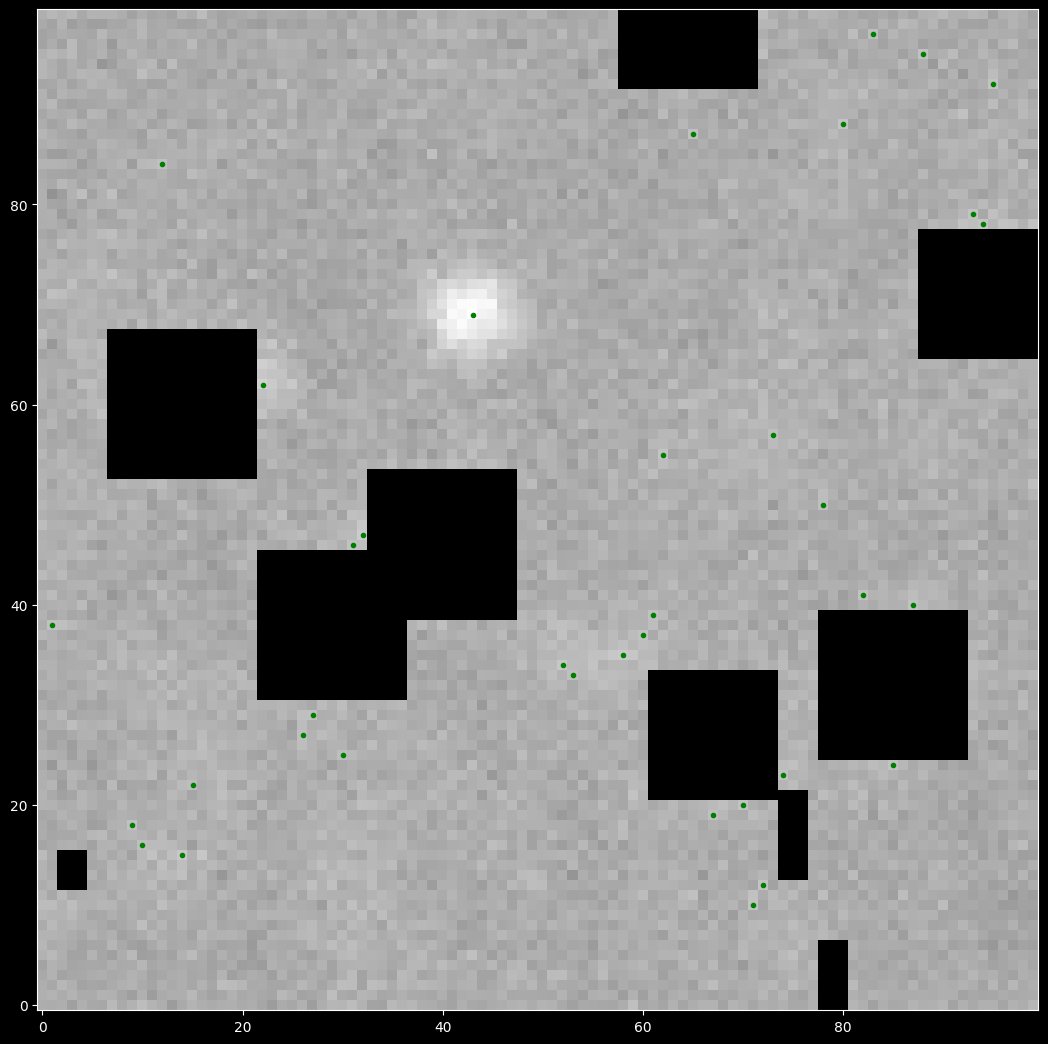

[0.00046433 0.0005475  0.00050991 0.00049792 0.0004794  0.
 0.00050148 0.00049589 0.00049658 0.00047661 0.0005256  0.00052194
 0.000534   0.         0.         0.00052852 0.00048608 0.00049316
 0.00048348 0.00051132 0.00048772 0.0004967  0.0005067  0.00046915
 0.00048111 0.00049782 0.         0.00051039 0.00053184 0.00053933
 0.00049455 0.0004793  0.00050224 0.00048595 0.00053281 0.00053054]
[0.         0.         0.         0.         0.00046433 0.00046915
 0.00047661 0.0004793  0.0004794  0.00048111 0.00048348 0.00048595
 0.00048608 0.00048772 0.00049316 0.00049455 0.00049589 0.00049658
 0.0004967  0.00049782 0.00049792 0.00050148 0.00050224 0.0005067
 0.00050991 0.00051039 0.00051132 0.00052194 0.0005256  0.00052852
 0.00053054 0.00053184 0.00053281 0.000534   0.00053933 0.0005475 ]
[ 1 29 12 34 28 35 15 10 11 19 27  2 22 32  6  3 25 21  8  7 30 17 20 16
 33 18 24  4 31  9 23  0 13 14  5 26]
(12, 72)
(79, 93)
(29, 27)
(95, 88)
(78, 94)
(97, 83)
(35, 58)
(25, 30)
(27, 26)
(40, 87)
(6

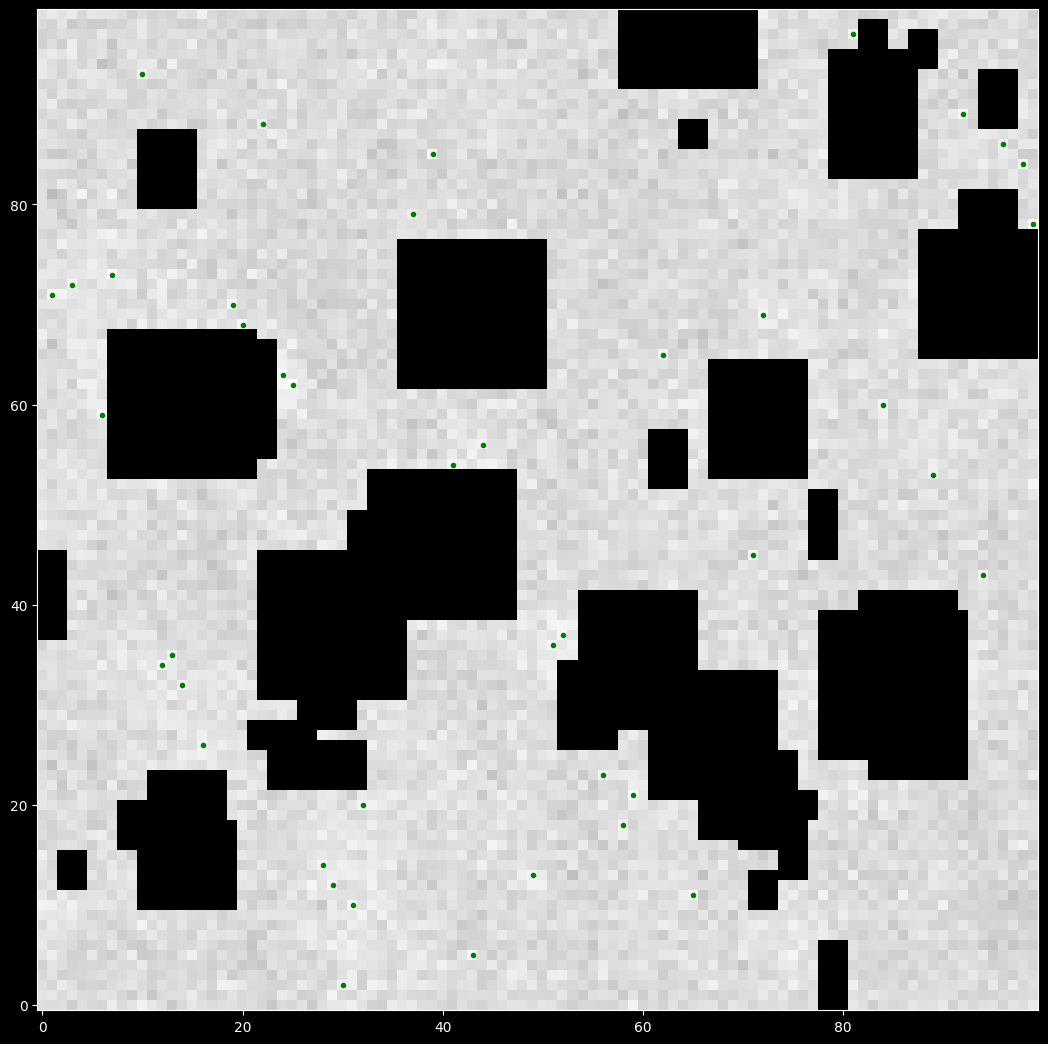

[0.00049655 0.00049051 0.00051435 0.         0.00054206 0.00048695
 0.00053197 0.         0.00054028 0.         0.         0.00051776
 0.00052846 0.00050402 0.00050513 0.         0.         0.0005032
 0.         0.00050725 0.         0.00049075 0.00048833 0.000514
 0.         0.         0.0004837  0.         0.00048304 0.
 0.00050272 0.00048358 0.00051961 0.00052263 0.         0.
 0.         0.0005009  0.00050394 0.00052963 0.00049138 0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00048304 0.00048358
 0.0004837  0.00048695 0.00048833 0.00049051 0.00049075 0.00049138
 0.00049655 0.0005009  0.00050272 0.0005032  0.00050394 0.00050402
 0.00050513 0.00050725 0.000514   0.00051435 0.00051776 0.00051961
 0.00052263 0.00052846 0.00052963 0.00053197 0.00054028 0.00054206]
[ 4  8  6 39 12 33 32 11  2 23 19 14 13 38 17 30 37  0 40 21  1 22  5 26
 31 28  7  9 10  3 41 

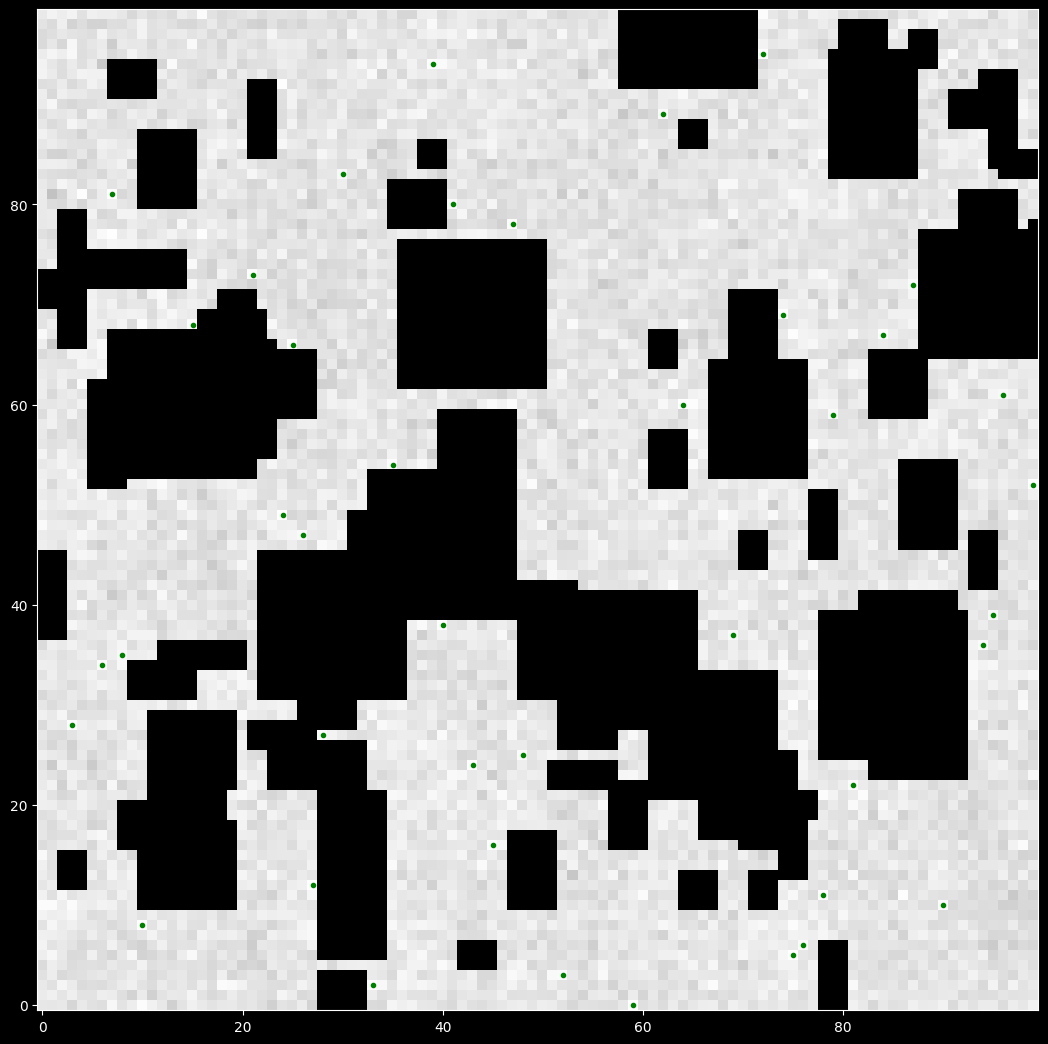

[0.00048212 0.00049745 0.00051517 0.         0.00051507 0.00049934
 0.00048826 0.00049589 0.         0.00047349 0.00049846 0.
 0.00052212 0.         0.         0.         0.00054106 0.00050277
 0.         0.         0.00049441 0.00051264 0.00049326 0.00046754
 0.         0.0004884  0.00050932 0.         0.         0.00051195
 0.00049327 0.00049868 0.00048514 0.         0.         0.00046168
 0.00049391 0.         0.0004941  0.00049637 0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00046168 0.00046754 0.00047349
 0.00048212 0.00048514 0.00048826 0.0004884  0.00049326 0.00049327
 0.00049391 0.0004941  0.00049441 0.00049589 0.00049637 0.00049745
 0.00049846 0.00049868 0.00049934 0.00050277 0.00050932 0.00051195
 0.00051264 0.00051507 0.00051517 0.00052212 0.00054106]
[16 12  2  4 21 29 26 17  5 31 10  1 39  7 20 38 36 30 22 25  6 32  0  9
 23 35 18 27 37  3 34 33 28  8 19

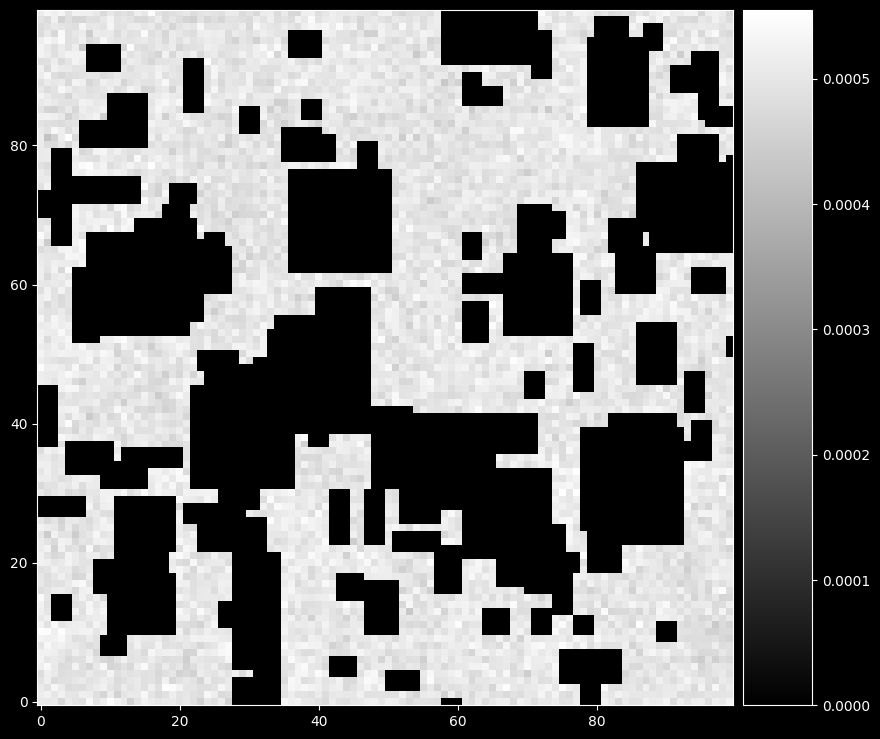

In [7]:
def find_maxima(data, display_plots: bool = False):
    xpos_max = np.argmax(data,axis=1)
    ypos_max = np.argmax(data,axis=0)
    pos_arr = np.arange(len(xpos_max))
    mat_xpos = [ (xpos_max[i],i) for i in pos_arr]
    mat_ypos = [ (i,ypos_max[i]) for i in pos_arr]
    match_pos = [ i in mat_ypos for i in mat_xpos]
    matches = np.array(mat_xpos)[match_pos].T
    if display_plots:
        plt.figure(figsize=(13,13))
        plt.imshow(data,cmap='gray',origin='lower')
        # plt.plot(xpos_max,pos_arr,'+',color='red')
        # plt.plot(pos_arr,ypos_max,'x',color='blue')
        plt.plot(*matches,'.g')
        plt.show()
    print(data[matches[0],matches[1]])
    print(np.sort(data[matches[0],matches[1]]))
    sort_pos = np.argsort(data[matches[0],matches[1]])[::-1]
    print(sort_pos)
    matches = matches[:,sort_pos]
    return matches

tmp_sci_frame = sci_frame.copy()
tmp_ind = find_maxima(sci_frame,True)
plt.figure()
plt.imshow(sci_frame,origin='lower')
plt.plot(*tuple(tmp_ind.T[0]),'o')
plt.show()
for tmpi in tmp_ind.T:
    tmpi = tuple(tmpi[::-1])
    print(tmpi)  
    tmp_xmax, tmp_ymax = tmpi
    if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
        if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: 
            print(tmp_sci_frame[tmp_xmax,tmp_ymax])
            break
        xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
        # compute slices
        tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
        tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
        # define the object
        tmp_obj = sci_frame[tmp_x,tmp_y].copy()
        tmp_sci_frame[tmp_x,tmp_y] = 0.0
        # plt.figure()
        # plt.imshow(tmp_obj,cmap='gray',origin='lower')
        # plt.figure()
        # plt.imshow(tmp_sci_frame,cmap='gray',origin='lower')
        # plt.show()
tmp_ind = find_maxima(tmp_sci_frame,True)
for tmpi in tmp_ind.T:
    tmpi = tuple(tmpi[::-1])
    print(tmpi)  
    tmp_xmax, tmp_ymax = tmpi
    if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
        if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
        xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
        # compute slices
        tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
        tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
        # define the object
        tmp_obj = sci_frame[tmp_x,tmp_y].copy()
        tmp_sci_frame[tmp_x,tmp_y] = 0.0
tmp_ind = find_maxima(tmp_sci_frame,True)
for tmpi in tmp_ind.T:
    tmpi = tuple(tmpi[::-1])
    print(tmpi)  
    tmp_xmax, tmp_ymax = tmpi
    if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
        if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
        xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
        # compute slices
        tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
        tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
        # define the object
        tmp_obj = sci_frame[tmp_x,tmp_y].copy()
        tmp_sci_frame[tmp_x,tmp_y] = 0.0
tmp_ind = find_maxima(tmp_sci_frame,True)
for tmpi in tmp_ind.T:
    tmpi = tuple(tmpi[::-1])
    print(tmpi)  
    tmp_xmax, tmp_ymax = tmpi
    if tmp_sci_frame[tmp_xmax,tmp_ymax] != 0.0:
        if tmp_sci_frame[tmp_xmax,tmp_ymax] <= mean_bkg+Dmean_bkg: break
        xsize, ysize = rst.new_grad_check(tmp_sci_frame,tmpi,mean_bkg+Dmean_bkg,debug_check=False)
        # compute slices
        tmp_x = slice(tmp_xmax - xsize[0], tmp_xmax + xsize[1]+1)
        tmp_y = slice(tmp_ymax - ysize[0], tmp_ymax + ysize[1]+1)
        # define the object
        tmp_obj = sci_frame[tmp_x,tmp_y].copy()
        tmp_sci_frame[tmp_x,tmp_y] = 0.0
dpl.fast_image(tmp_sci_frame)


#### I method


- - - SEARCHING START - - -
Stop_val : 0.0005234011595901208

	hwhm 5
	hm_pos 10
	sigma 3.6067376022224087
	dim :  11 11
	cen :  5 5
	x :  0 11
	y :  0 11
	val0 0.0012246721326269684
	cen :  5 5
	shift [0 0]
	val1 0.0012246721326269684
	cen :  5 5
	shift [0 0]
	val1 0.0012246721326269684

sigma0 = 3.060418339790368

Fit results:
	k: 0.00073 +- 3.1e-05
	sigma: 2.9 +- 0.083
	x0: 4.9 +- 0.13
	y0: 3.9 +- 0.14
	red_chi = 7.68 +- 13.07 %

	hwhm 4
	hm_pos 9
	sigma 2.8853900817779268
	dim :  11 11
	cen :  5 4
	x :  1 10
	y :  0 9
	val0 0.001203079174729971
	cen :  4 4
	shift [1 0]
	val1 0.001203079174729971
	cen :  4 4
	shift [1 0]
	val1 0.001203079174729971

sigma0 = 3.225964182229561

Fit results:
	k: 0.0005 +- 2.2e-05
	sigma: 2.8 +- 0.085
	x0: 5.1 +- 0.14
	y0: 6.0 +- 0.14
	red_chi = 15.70 +- 13.07 %

sigma0 = 2.600855472391387

Fit results:
	k: 0.00048 +- 2.4e-05
	sigma: 2.7 +- 0.082
	x0: 4.9 +- 0.14
	y0: 5.0 +- 0.14
	red_chi = 29.15 +- 13.07 %

sigma0 = 2.281101149119438

Fit results:
	k:

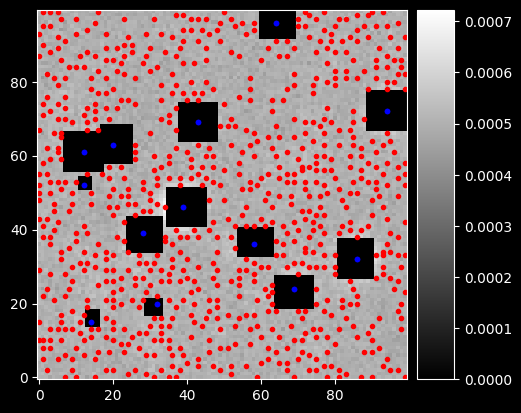

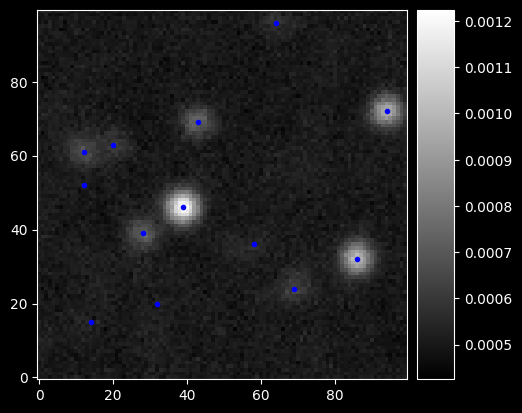


sigma0 = 2.0402788931935794

Fit results:
	k: 0.00073 +- 2.6e-05
	sigma: 3.0 +- 0.082
	x0: 4.9 +- 0.13
	y0: 4.0 +- 0.14
	red_chi = 5.28 +- 13.07 %

sigma0 = 2.0402788931935794

Fit results:
	k: 0.00051 +- 1.7e-05
	sigma: 3.0 +- 0.089
	x0: 5.1 +- 0.14
	y0: 5.0 +- 0.15
	red_chi = 6.41 +- 13.74 %

sigma0 = 2.600855472391387

Fit results:
	k: 0.00049 +- 1.9e-05
	sigma: 2.9 +- 0.082
	x0: 4.9 +- 0.14
	y0: 5.1 +- 0.14
	red_chi = 15.10 +- 13.07 %

sigma0 = 2.974192019569993

Fit results:
	k: 0.00024 +- 1.1e-05
	sigma: 2.9 +- 0.11
	x0: 4.8 +- 0.16
	y0: 4.3 +- 0.16
	red_chi = 30.52 +- 14.43 %

sigma0 = 2.8853900817779268

Fit results:
	k: 0.00025 +- 1.3e-05
	sigma: 2.8 +- 0.099
	x0: 5.1 +- 0.15
	y0: 4.9 +- 0.15
	red_chi = 35.41 +- 13.07 %

sigma0 = 2.281101149119438

Fit results:
	k: 0.00019 +- 9e-06
	sigma: 3.1 +- 0.12
	x0: 5.3 +- 0.16
	y0: 5.3 +- 0.16
	red_chi = 40.89 +- 13.07 %

sigma = 2.97890 +- 0.08498 -> 2.9 %


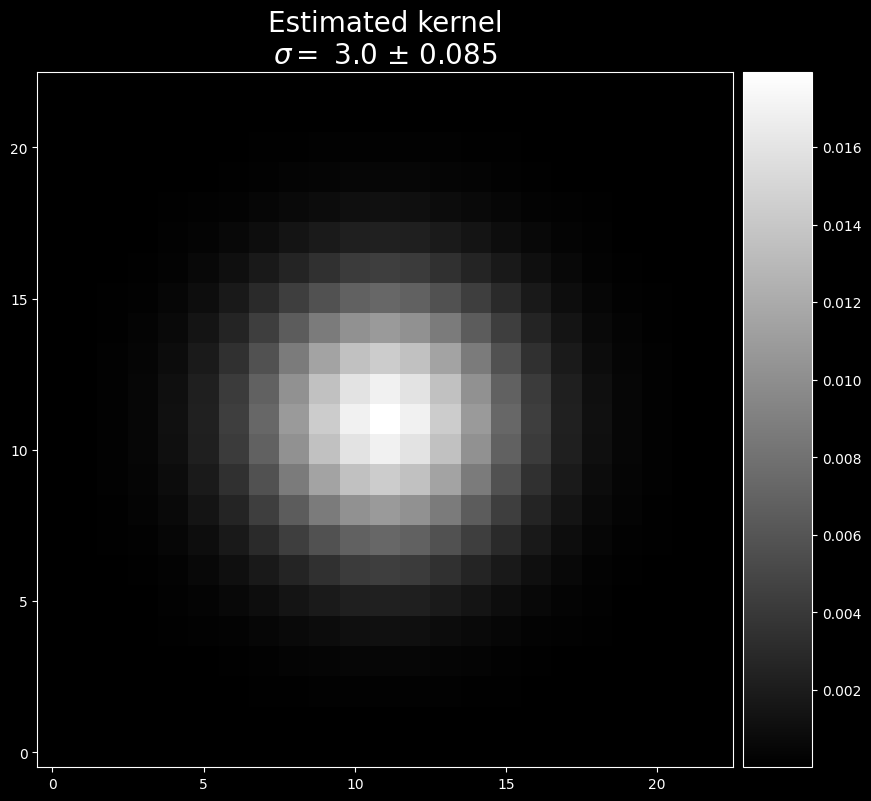

In [8]:
Dmean_bkg = sigma_bkg
trial = sci_frame - mean_bkg
# extract objects for the kernel recovery
objs, errs, pos = rst.searching(sci_frame, mean_bkg+Dmean_bkg, sigma, max_size=max_size, min_dist=2, display_fig=False,**kwargs)
# objs, errs, pos = rst.searching(trial, Dmean_bkg, sigma, max_size=max_size, min_dist=2, display_fig=False,**kwargs)
obj0 = np.copy(objs[0])
# estimate kernel
ker_sigma, ker_Dsigma = rst.kernel_estimation(objs[:6], errs[:6], m_bkg, display_plot=False,**kwargs)
# ker_sigma, ker_Dsigma = rst.kernel_estimation(objs[:6], errs[:6], (0,Dmean_bkg), display_plot=False,**kwargs)
# compute the estimated kernel
kernel = stf.Gaussian(ker_sigma)


[ 6.90900925e-04 -7.24692794e-01  3.76016665e+00] [2.18571649e-05 2.81157107e-01 1.46597742e-01]
[0.00120308]
[0.00119418]


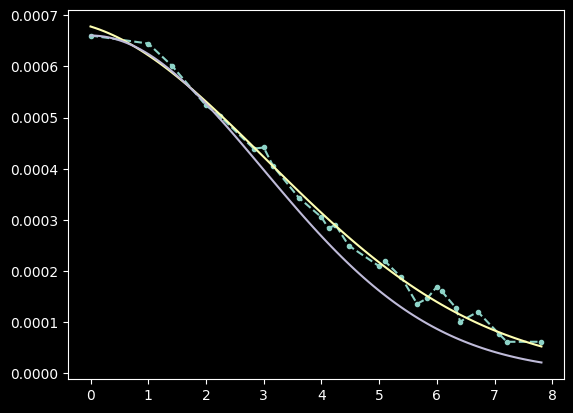

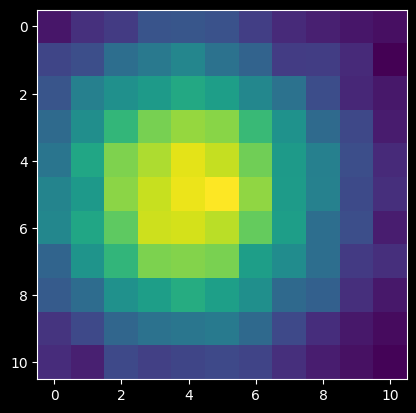

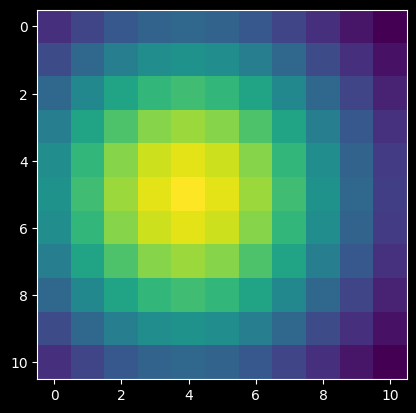

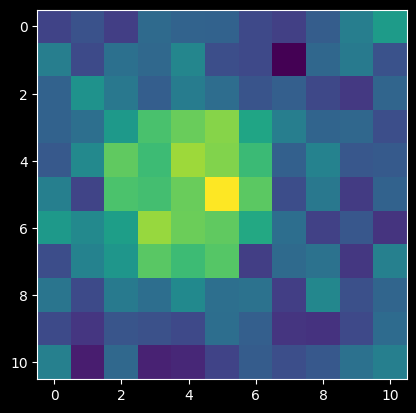

In [9]:

prb_obj = obj0
prb_x, prb_y = pos[:,0]
avg_cen = np.where(prb_obj == sci_frame[prb_x,prb_y])
avg_dist, avg_obj = rst.average_trend(prb_obj,avg_cen)
avg_obj -= mean_bkg
plt.figure()
plt.plot(avg_dist,avg_obj,'.--')

def gauss_func(x,*args):
    k,mu,sigma = args
    z = (x-mu)/sigma
    return k * np.exp(-z**2/2)
from scipy.optimize import curve_fit
avgmax = np.argmax(avg_obj)
hm = avg_obj[avgmax]/2
hm_pos = np.argmin(abs(hm-avg_obj))
hwhm = abs(avg_dist[avgmax]-avg_dist[hm_pos])
initial_values = [2*hm,0,ker_sigma]
pop, pcov = curve_fit(gauss_func,avg_dist,avg_obj,initial_values)
print(pop,np.sqrt(pcov.diagonal()))
xx = np.linspace(0,avg_dist.max(),100)
plt.plot(xx,gauss_func(xx,*pop))
plt.plot(xx,gauss_func(xx,*initial_values))

xdim, ydim = prb_obj.shape
yrange, xrange = np.meshgrid(np.arange(xdim),np.arange(ydim))
zeta = np.sqrt((xrange-avg_cen[0])**2+(yrange-avg_cen[1])**2)/pop[-1]
rec_obj = np.exp(-zeta**2/2)
rec_obj = pop[0]*rec_obj+mean_bkg
print(prb_obj[avg_cen])
print(rec_obj[avg_cen])
plt.figure()
plt.imshow(prb_obj)
plt.figure()
plt.imshow(rec_obj)
plt.figure()
plt.imshow(prb_obj-rec_obj)
plt.show()


### R-L

Dn 6.856133315823215e-06
Dn 5.818491147512232e-07
Dn 1.3214397815455167e-06
2220: - diff 1.321e-06	chisq 1.649e-09
Time: 109.44051861763 s



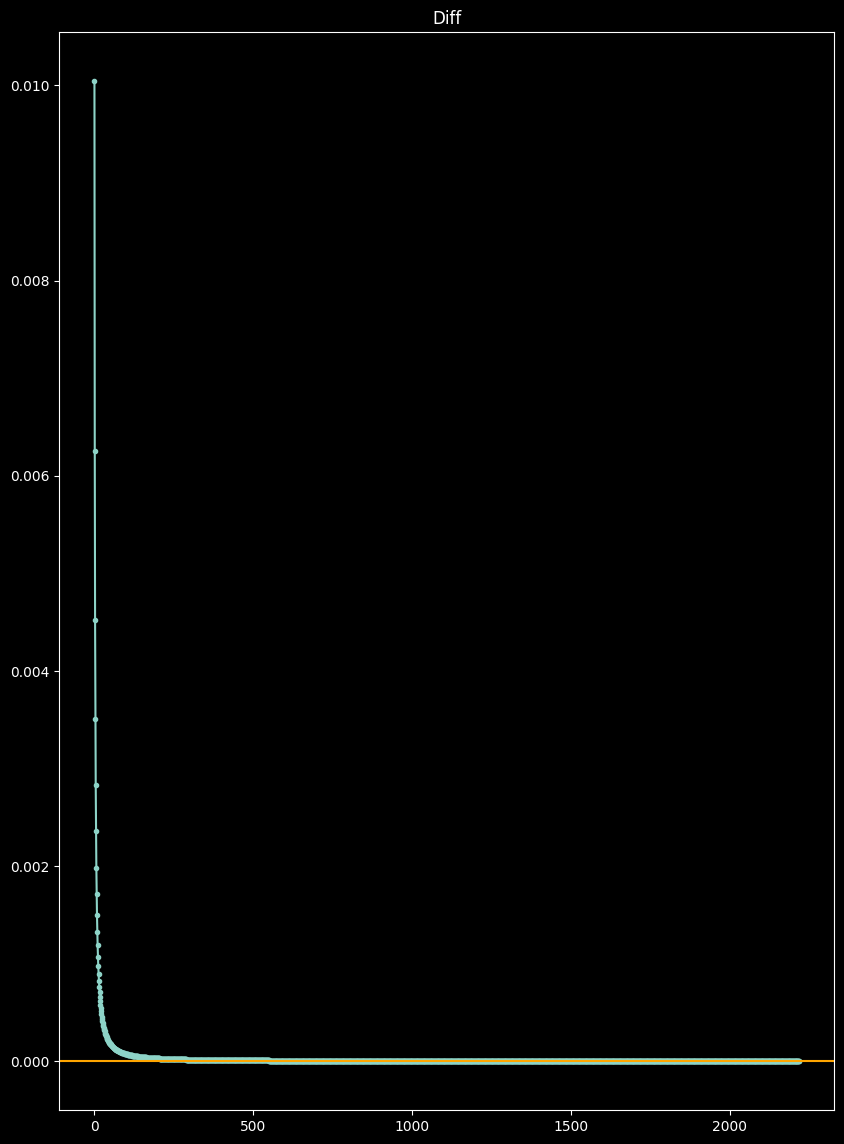

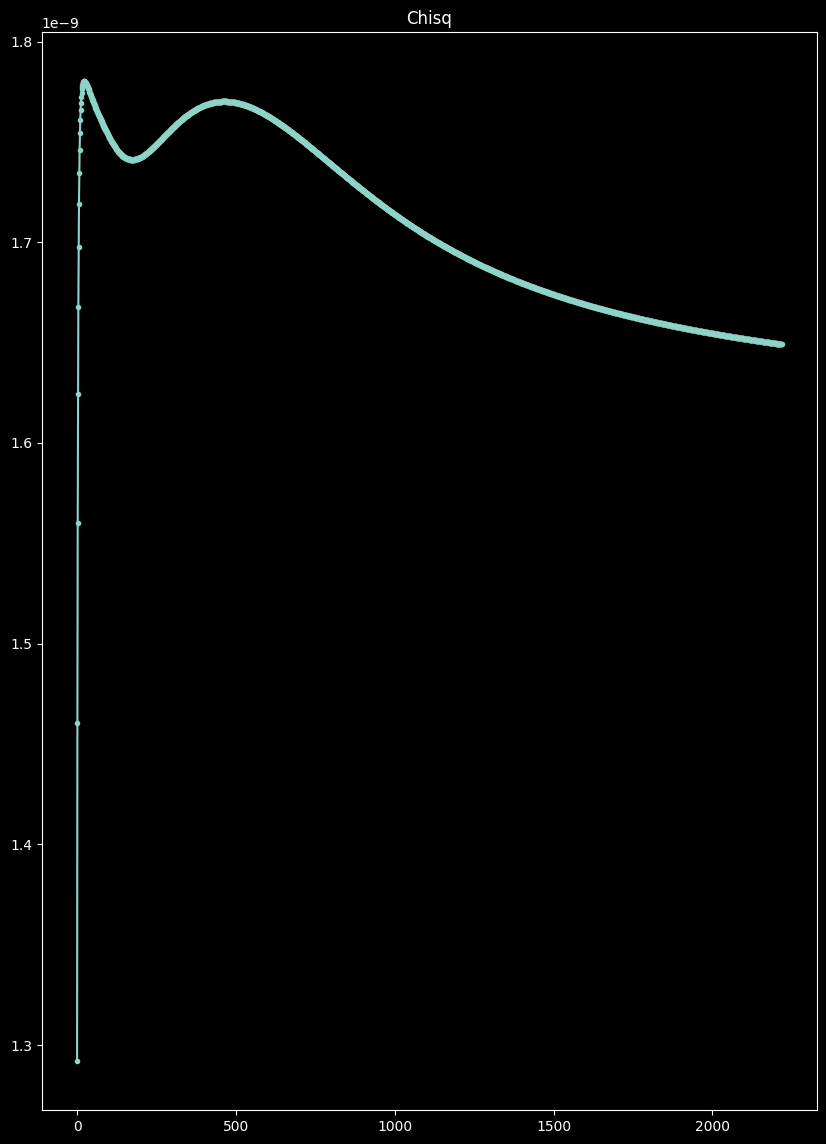

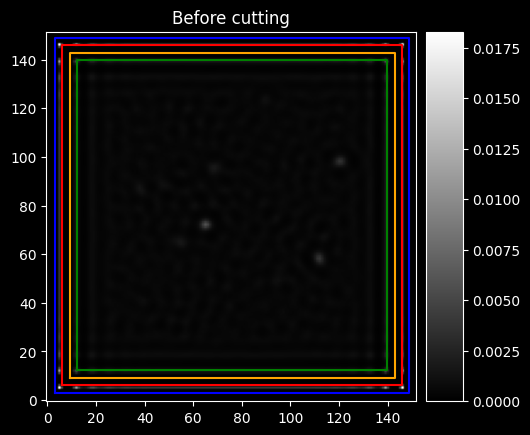

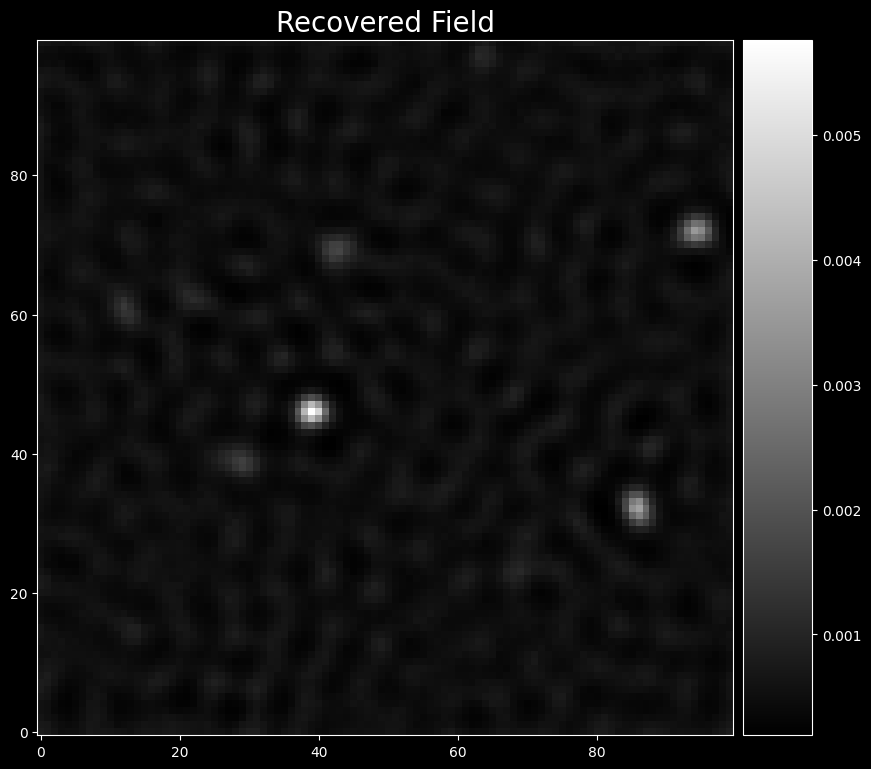

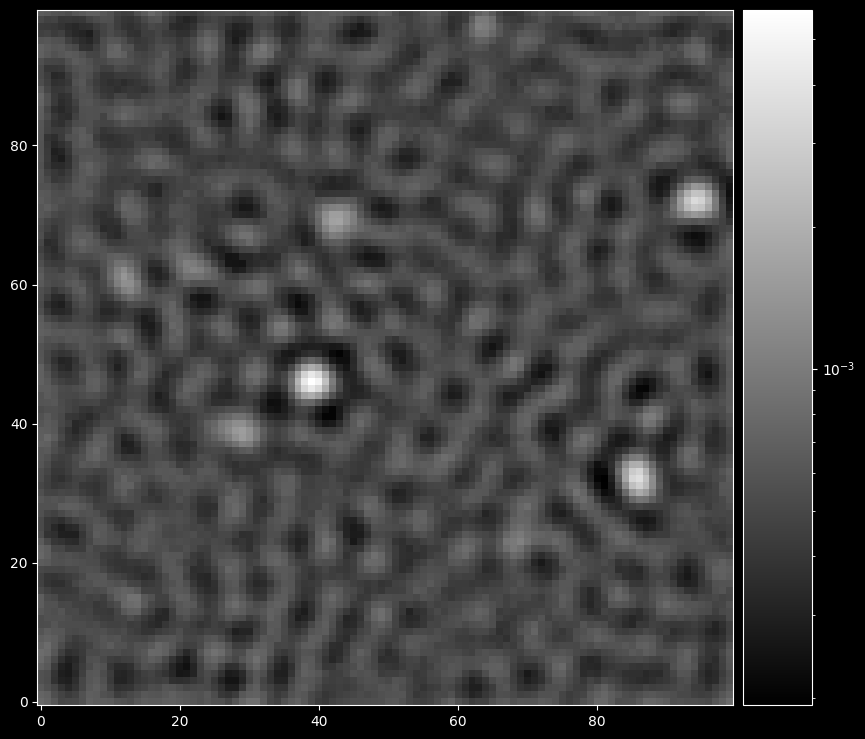

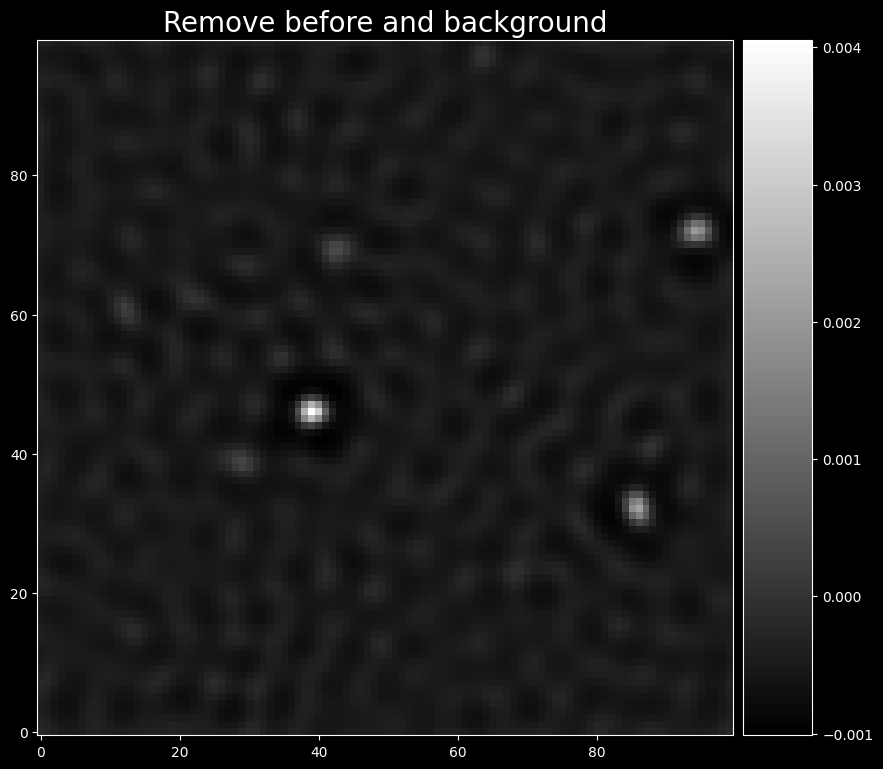

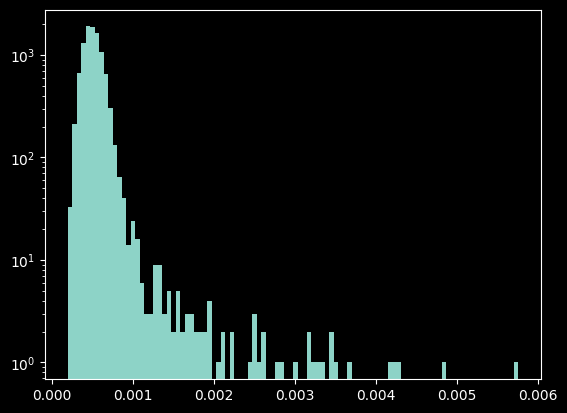

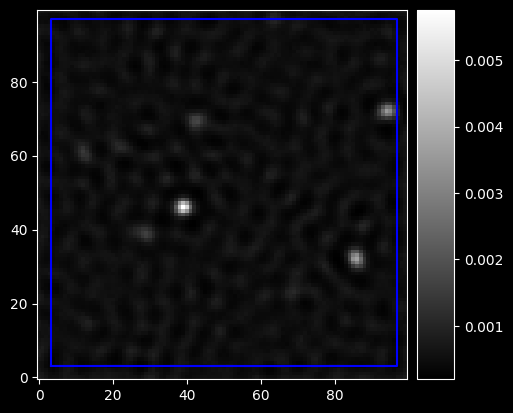

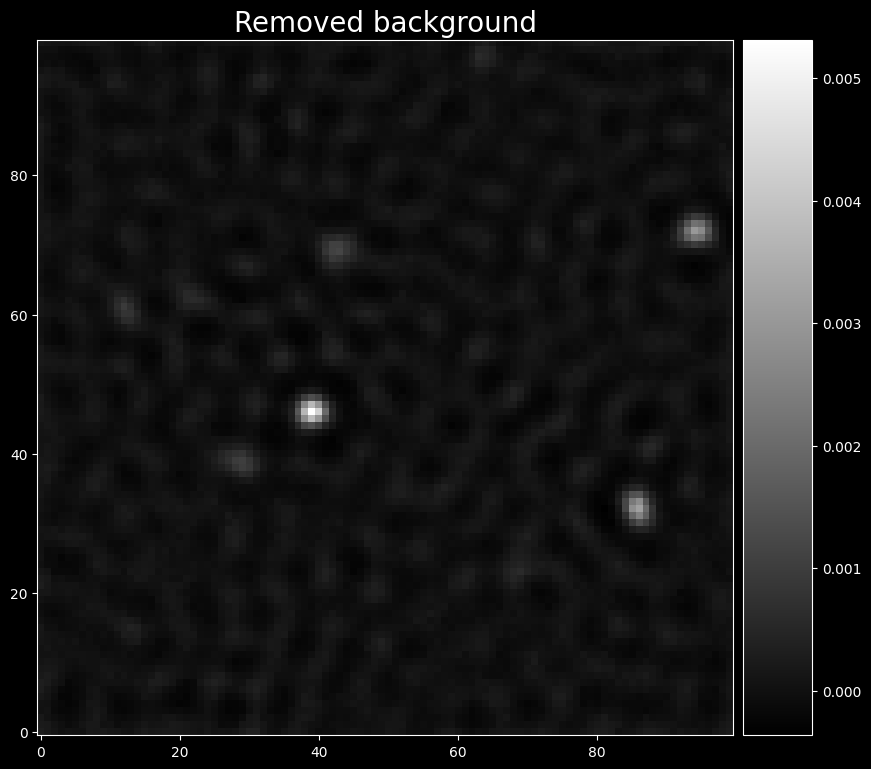

In [13]:
thr_mul = 1/sci_frame.sum()
# mode = {'fillvalue': 0}
# mode = {'boundary': 'symm'}
mode = None
rec_field = rst.LR_deconvolution(sci_frame,kernel,sigma, mean_bkg, sigma_bkg,mode=mode,thr_mul=thr_mul, display_fig=True)
dpl.fast_image(rec_field - sci_frame - mean_bkg,'Remove before and background')
flat_field = rec_field.flatten()
plt.figure()
plt.hist(flat_field,100)
plt.yscale('log')

fig, ax = plt.subplots(1,1)
dim = len(rec_field)
dpl.field_image(fig, ax, rec_field)
mask0 = sqr_mask(ker_sigma, dim)
ax.plot(mask0[:,0], mask0[:,1], color='blue')
plt.show()

last_sen += [f'L2: {rec_field.max()*np.sqrt(18*np.pi)}']
art_bkg = stf.Gaussian(sigma_bkg, mean_bkg).field(rec_field.shape)
dpl.fast_image(rec_field - art_bkg, 'Removed background')



## Find Stars

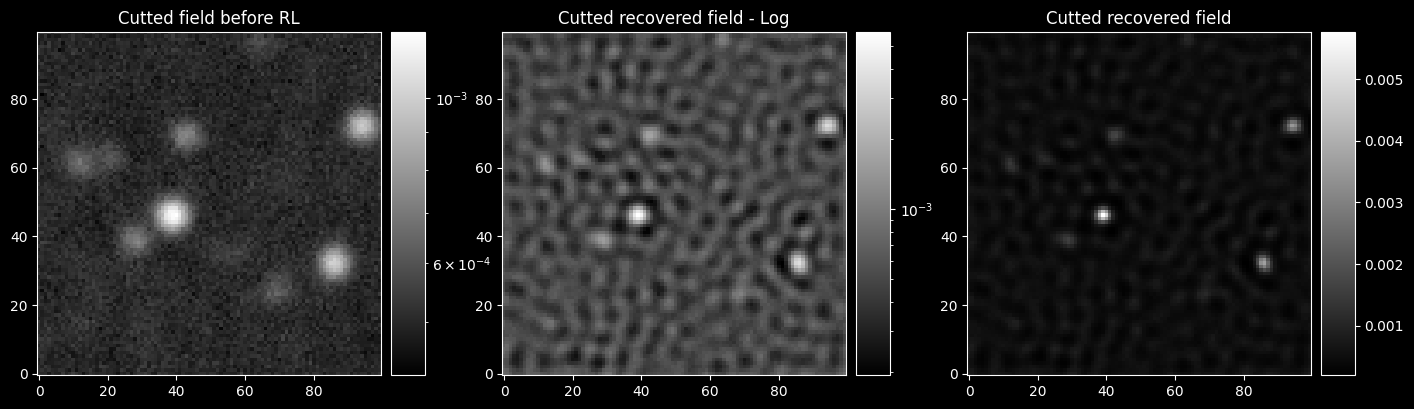

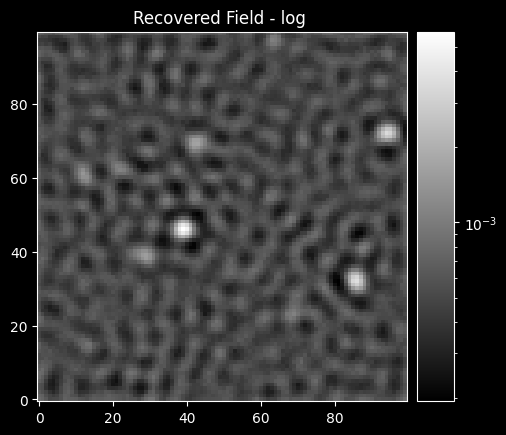


- - - SEARCHING START - - -
Stop_val : 0.0005234011595901208

- - - -
Step 1
	coor : (46, 39)
	peak : 0.005760161706481263
[4 4] [5 4]


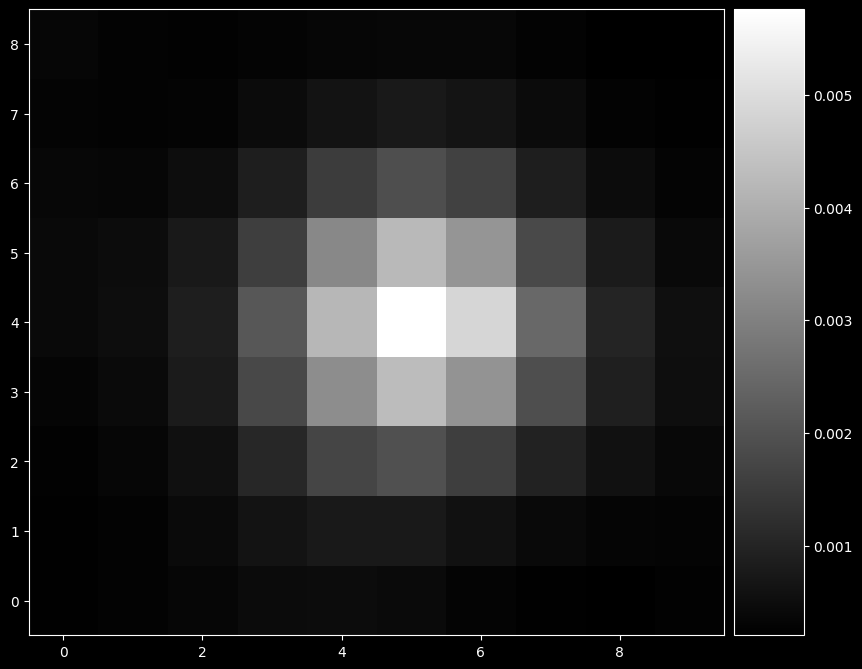

SHAPE:  (9, 10)
          c s
x compare 4 [4 4]
y compare 5 [5 4]
	shape : (9, 10)
LOW
0 9
0 10

	hwhm 5
	sigma 3.6067376022224087
	dim :  9 10
	cen :  4 5
	x :  0 9
	y :  0 10

sigma0 = 1.0201394465967897

Fit results:
	k: 0.01 +- 0.0068
	sigma: 0.91 +- 0.13
	x0: 4.0 +- 0.23
	y0: 5.0 +- 0.22
	red_chi = 6477.24 +- 15.25 %
0 9
0 10
zero 4 5
shift [0 0]
zero 4 5
shape (9, 10)
RATIO 1144.525938% %
NO GOOD
Check is not good 1

- - - -
Step 2
	coor : (32, 86)
	peak : 0.003692554899881743
[5 4] [4 4]


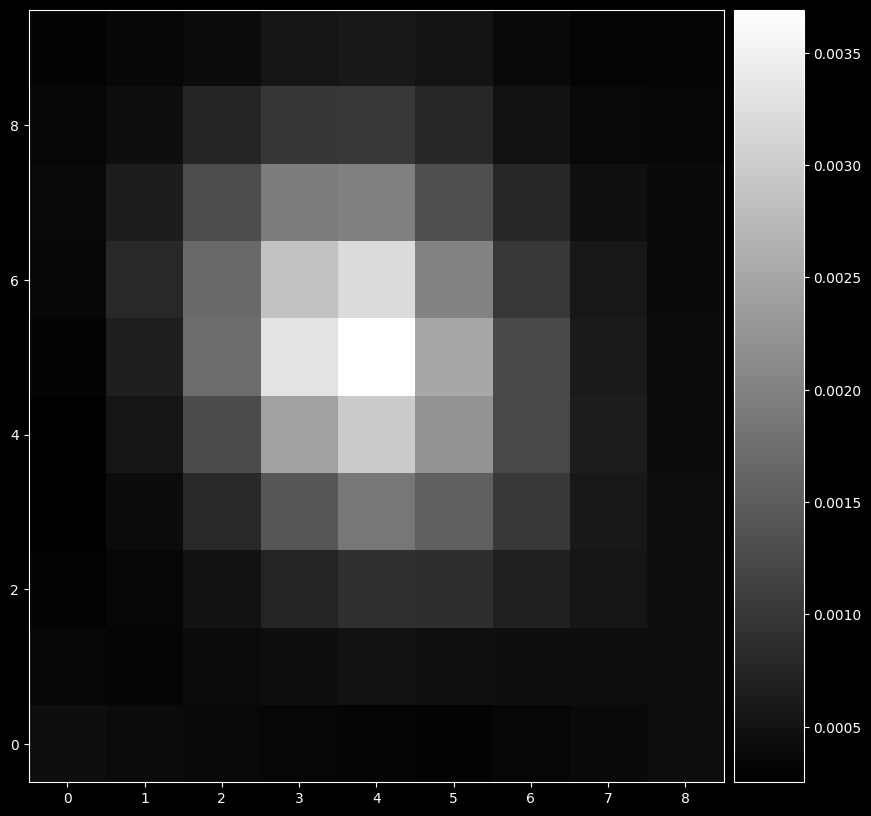

SHAPE:  (10, 9)
          c s
x compare 5 [5 4]
y compare 4 [4 4]
	shape : (10, 9)
LOW
0 10
0 9

	hwhm 5
	sigma 3.6067376022224087
	dim :  10 9
	cen :  5 4
	x :  0 10
	y :  0 9

sigma0 = 1.0201394465967897

Fit results:
	k: 0.0071 +- 0.0047
	sigma: 0.97 +- 0.13
	x0: 5.1 +- 0.2
	y0: 4.1 +- 0.22
	red_chi = 5547.48 +- 15.25 %
0 10
0 9
zero 5 4
shift [0 0]
zero 5 4
shape (10, 9)
xsize (27, 37)
ysize (82, 91)
[3.30064892e-03 1.37177272e+00 3.79087214e+00 5.10376623e+00] [9.59374878e-05 2.81979772e-02 3.98689960e-02 3.98684969e-02]
CENVAL 0.003692554899881743
CENVAL 0.0037564738666111134

- - - -
Step 3
	coor : (72, 94)
	peak : 0.0035185465835268883
SHAPE:  (9, 9)
          c s
x compare 4 [4 4]
y compare 4 [4 4]
	shape : (9, 9)

	First cut

	hwhm 2
	hm_pos 6
	sigma 1.4426950408889634
	dim :  9 9
	cen :  4 4
	x :  2 7
	y :  2 7
	val0 0.0035185465835268883
	cen :  2 2
	shift [2 2]
	val1 0.0035185465835268883
	cen :  2 2
	shift [2 2]
	val1 0.0035185465835268883

sigma0 = 1.0201394465967897

Fi

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



Fit results:
	k: 0.0012 +- 0.0039
	sigma: 0.72 +- 0.36
	x0: 4.7 +- 0.3
	y0: 2.6 +- 0.32
	red_chi = 850.17 +- 19.61 %
xsize (14, 21)
ysize (54, 61)
[ 3.92556857e-05  1.49325351e+00 -3.50855355e+00  1.50078331e+01] [inf inf inf inf]
CENVAL 0.0005701990783146815
CENVAL 0.0005032792632691882

- - - -
Step 215
	coor : (52, 98)
	peak : 0.000643253723727881
SHAPE:  (6, 4)
          c s
x compare 4 [4 1]
y compare 3 [2 3]
col 3 0
[2 0]
x compare 4 [4 1]
y compare 3 [2 0]
remove
New Shape is too small

- - - -
Step 216
	coor : (30, 71)
	peak : 0.0006429895305617141
SHAPE:  (4, 5)
          c s
x compare 0 [2 1]
y compare 1 [2 2]
row 0 3
[1 1]
x compare 0 [1 1]
y compare 1 [2 2]
remove
New Shape is too small

- - - -
Step 217
	coor : (53, 5)
	peak : 0.0006428476623894474
SHAPE:  (6, 7)
          c s
x compare 2 [2 3]
y compare 3 [3 3]

sigma0 = 2.281101149119438

Fit results:
	k: 0.00089 +- 0.0019
	sigma: 0.82 +- 0.33
	x0: 1.3 +- 0.35
	y0: 3.1 +- 0.26
	red_chi = 852.19 +- 22.94 %
xsize (51, 57)

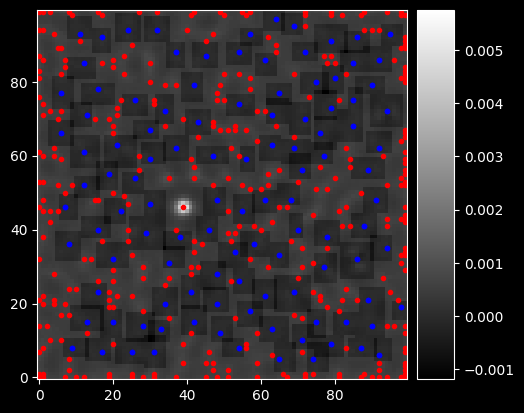

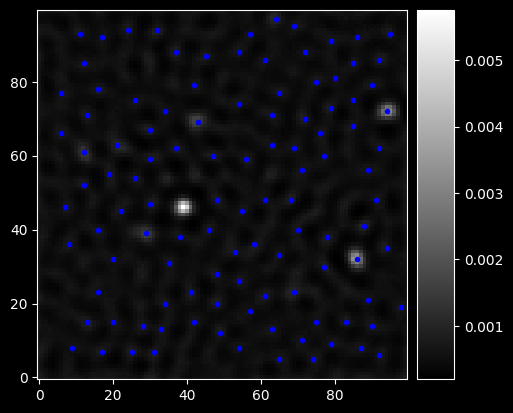

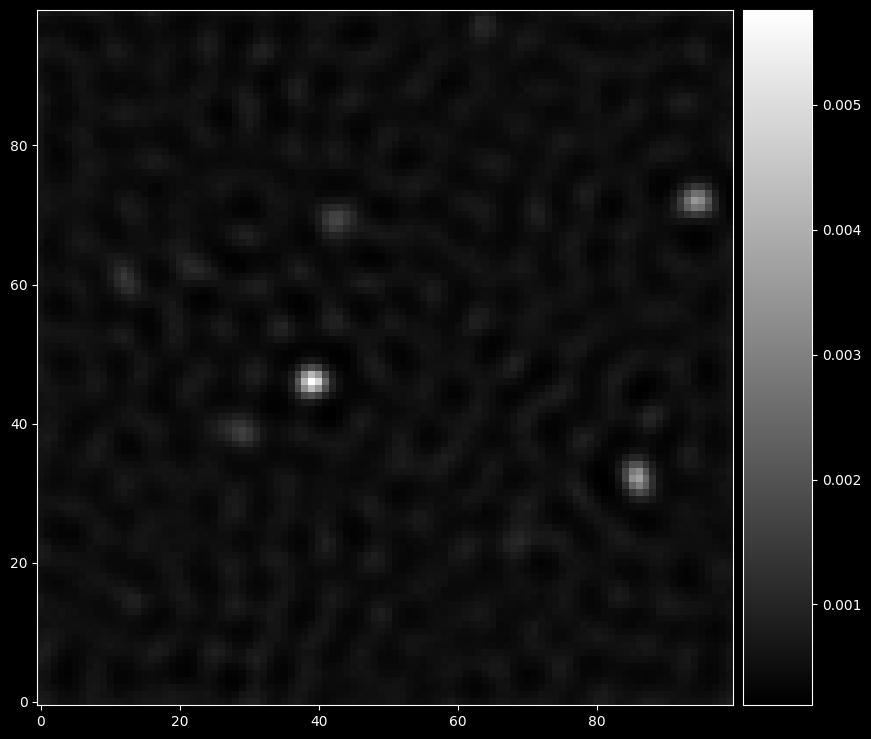

In [22]:
cut_slice = slice(None,None)
# cut_slice = slice(20,-19)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,19))
ax1.set_title('Cutted field before RL')
dpl.field_image(fig,ax1,sci_frame[cut_slice,cut_slice],norm='log')
fig, ax = plt.subplots(1,1)
ax.set_title('Recovered Field - log ')
dpl.field_image(fig,ax,rec_field,norm='log')
tmp_field = rec_field[cut_slice,cut_slice]
ax2.set_title('Cutted recovered field - Log')
dpl.field_image(fig,ax2,tmp_field,norm='log')
ax3.set_title('Cutted recovered field')
dpl.field_image(fig,ax3,tmp_field)
plt.show()
objs, err, obj_pos = searching(tmp_field, mean_bkg+Dmean_bkg, mean_bkg, errs=sigma, max_size=5, cntrl=None, cntrl_sel='bright', debug_plots=False,log='True')
# objs, err, pos = rst.searching(rec_field, mean_bkg*105e-100, sigma, max_size=5, cntrl=None, cntrl_sel='bright', debug_plots=False)

dpl.fast_image(tmp_field)


### Lum Recovery

$$ f(M) = M^{-\alpha} $$
$$ L = K\; M^{\beta} $$
$$ f(M)dM = f(L)dL $$
$$ f(L) = \frac{1}{\beta} \Bigl ( \frac{L}{K} \Bigr )^{(1-\alpha-\beta)/\beta} $$

In [ ]:
lum = S.lum
maxvalues  = np.array([ tmp_field[x,y] for x, y in zip(*obj_pos)])
val_obj0 = maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)
err_obj0 = tmp_field[obj_pos[1,0],obj_pos[0,0]]
err_obj0 = np.sqrt((err_obj0/maxvalues.max())**2 + (ker_Dsigma/ker_sigma)**2) * val_obj0
print('sigma',ker_sigma)
print('\nLuminosities:')
for sen in last_sen:
    print(sen)
print(f'L3: {maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)} +/- {err_obj0}')
print(f'L4: {objs[0].max()*np.sqrt(2*np.pi*ker_sigma**2)}')
val = maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)
print('OK' if val - err_obj0 <= lum.max() <= val + err_obj0 else 'NO', f'- {abs(val-lum.max())/err_obj0:.2f}')
print('VAL',maxvalues.max()*np.sqrt(2*np.pi*ker_sigma**2)/lum.max(),err_obj0/lum.max())
print('VAL',(maxvalues.max()+m_dark.mean())*np.sqrt(2*np.pi*ker_sigma**2)/lum.max())

maxvalues *= np.sqrt(2*np.pi*ker_sigma**2)
# from scipy.integrate import trapezoid
# maxvalues = np.array([ trapezoid(trapezoid(obj)) for obj in objs])
plt.figure(figsize=(10,14))
binnn = lambda arr : 10**(np.linspace(np.log10(arr).min(),np.log10(arr).max(),10))
plt.hist(maxvalues,50, histtype='step',color='red',label='Max Val')
plt.hist(lum,60, histtype='barstacked', label='Lum',color='blue',alpha=0.7)
# plt.xscale('log')
# plt.axvline(np.mean(maxvalues),0,1,linestyle='dashed',color='red')
# plt.axvline(np.mean(lum),0,1,linestyle='dashed',color='blue')
# plt.axvline(mean_bkg,0,1,linestyle='-.',color='violet',label='mean_bkg')
plt.yscale('log')
plt.legend()
plt.show()
print(f'\n\n------\n\nFOUND:\t{len(objs)}\nOBSER:\t{len(lum[lum>mean_bkg])}')

# ## Expectation Values
# def power_law(x, n, k):
#     return k*x**n

# maxvalues *= np.sqrt(2*np.pi*ker_sigma)
# cnts, bins = np.histogram(maxvalues,40)

# pos = np.argmax(cnts)
# cnts = cnts[pos:]
# bins = bins[pos:]

# xdata = (bins[1:]+bins[:-1])/2
# xerr  = (bins[1:]-bins[:-1])/2
# xdata = xdata[cnts!=0]
# xerr  = xerr[cnts!=0]
# ydata = cnts[cnts!=0]
# fit = rst.FuncFit(xdata=xdata,xerr=xerr,ydata=ydata)
# fit.pipeline(power_law,[-1,cnts.max()],names=['-a/b','K'])
# (n,k), (Dn,Dk) = fit.results()

# plt.figure()
# xx = np.linspace(xdata.min(),xdata.max(),300)
# plt.subplot(2,1,1)
# plt.errorbar(xdata,ydata,xerr=xerr,fmt='.')
# plt.plot(xx,power_law(xx,*fit.fit_par))
# plt.plot(xx,k*xx**(-4/3))
# plt.subplot(2,1,2)
# plt.errorbar(xdata,ydata-power_law(xdata,n,k),abs(n*power_law(xdata,n,k)*xerr/xdata),fmt='.')
# plt.axhline(0,0,1,color='w')

# plt.figure()
# plt.stairs(cnts,bins)
# distr = power_law(xdata,n,k)
# plt.plot(xdata,cnts.max()*distr/distr.max())
# plt.show()


# plt.figure(figsize=(10,14))
# lum = np.sort(lum)
# cnts, bins, _ = plt.hist(lum,80)
# blum = (bins[1:]+bins[:-1])/2
# len(blum)
# ydata = blum**(-4/3)
# plt.plot(blum,cnts.max()*ydata/ydata.max())
# plt.xscale('log')

# plt.figure()
# mass = np.sort(star.m)
# cnts, bins, _ = plt.hist(mass,80)
# plt.plot(bins,mass**(-fld.ALPHA))
# plt.xscale('log')
# plt.show()
# a = -2
# b  = a/n
# Db = b * Dn/n
# exp_val0 = 3/4 * (lum.max()**(3/4) - lum.min()**(3/4))
# exp_val  = b/(b-1)/2 * (maxvalues.max()**(2*(b-1)/b) - maxvalues.min()**(2*(b-1)/b))


# print('EXP',exp_val,exp_val0)

# plt.figure()
# plt.hist(maxvalues,30, histtype='step',color='red',label='Max Val')
# plt.hist(lum,60, histtype='step', label='Lum',color='blue')
# plt.axvline(exp_val,0,1,color='red',linestyle='--',label=f'{exp_val}')
# plt.axvline(exp_val0,0,1,color='blue',linestyle='--',label=f'{exp_val0}')
# plt.show()



## Test

In [ ]:
import skysimulation as sks
import numpy as np
import matplotlib.pyplot as plt

F,S =  sks.initialize()
Fseeing = sks.atm_seeing(F)
fig, ax = plt.subplots(1,1)
sks.field_image(fig,ax,Fseeing)
plt.show()

bkg, bkg_sigma = sks.bkg_est(Fseeing)
obj,err,pos = sks.searching(Fseeing,bkg[0],)
sigma, Dsigma = sks.kernel_estimation(obj,err,bkg)


In [ ]:
max_iter = 1000
mode = {'boundary':'symm'}
S = sks.LR_deconvolution(Fseeing,sks.Gaussian(sigma),Fseeing*1e-1000,bkg[0],bkg_sigma,max_iter=max_iter,mode=mode)
fig, ax = plt.subplots(1,1)
sks.field_image(fig,ax,S)
plt.show()



In [ ]:
fig, ax = plt.subplots(1,1)
sks.field_image(fig,ax,S,norm='log')
plt.show()
tmp_S = S[7:-6,7:-6]
objs = []
pos  = []
tmp = tmp_S.copy()
dist = lambda p1,p2: np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
cnt = 0
for _ in range(1000):
    pos += [[*sks.peak_pos(tmp)]]
    tmp[pos[cnt]] = 0
    if cnt > 0: 
        p1 = pos[cnt-1]
        p2 = pos[cnt]
        print(dist(p1,p2))
        if dist(p1,p2) <= 2:
            pos.remove([*p2])
        else:
            objs += [tmp_S[pos[cnt]]]
            cnt += 1
    else:
        cnt+=1
fig, ax = plt.subplots(1,1)
sks.field_image(fig,ax,tmp_S)
for p in pos:
    x,y = p
    ax.plot(x,y,'.b')
plt.show()
